In [1533]:
import numpy as np
import matplotlib.pyplot as plt
import pydot
import pickle
import pathlib
import os
from scipy import stats
import random
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [10, 5]
#import unicode

from scipy.optimize import curve_fit
import re
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import statistics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [1534]:
#directory = str(pathlib.Path(__file__).parent.resolve())
#script_path = str(pathlib.Path(__file__).parent.resolve())
directory = os.getcwd()
script_path = os.getcwd()
nameset,dictset = [],[]
refnameset,refdictset = [],[]

refsortset = []
sortset = []


for filename in os.listdir(directory):
    if filename.endswith(".txt") and '._' not in filename:
        if 'REF' not in filename:
            impath = os.path.join(directory, filename)
            nameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',')
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            dictset.append(this_set)
            sortset.append((impath, this_set))
        else:
            impath = os.path.join(directory, filename)
            refnameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',')
                    #if pog[0] == 'P4': print(pog[0],pog[-1].count(','))
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            refdictset.append(this_set)
            refsortset.append((impath, this_set))
            
    
print(len(dictset),len(nameset))
print(len(refdictset),len(refnameset))
truncator = len(nameset)

nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(n[1])

refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(n[1])
    
fulldictset = refdictset + dictset;fullnameset = refnameset + nameset

1322 1322
30 30


In [1535]:
def remove_dangling_children(oldshi,ref = False):
    poor = ['']+sorted(list(oldshi))+['xxxxxxxxxxxxxxxxx'];dishi = dict()
    if ref == True:
        dishi['ABa'] = oldshi['ABa']
        dishi['P2'] = oldshi['P2']
        dishi['P3'] = oldshi['P3']
    
    try: 
        dishi['ABa'] = oldshi['ABa']
        dishi['P2'] = oldshi['P2']
        dishi['P3'] = oldshi['P3']
        #print('here')
    except: pass
    #print('P2' in oldshi)
    for n in range(1,len(poor)-1):
        if (len(poor[n]) == len(poor[n+1]) or len(poor[n]) == len(poor[n-1])) == False: 
            dishi[poor[n]] = oldshi[poor[n]]
    return dishi


In [1536]:
refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(remove_dangling_children(n[1], ref = True))

In [1537]:
nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(remove_dangling_children(n[1]))

In [1538]:
#part 1 of common node
refnodelist = set(refdictset[0])
for n in refdictset:
    refnodelist = set(n).intersection(refnodelist)

In [1539]:
#part 2 of common node
newdictset = []
for n in refdictset:
    newdict = dict()
    for i in refnodelist:
        newdict[i] = n[i]
    #print(set(newdict).issubset(set(n)))
    #print(len(newdict))
    newdictset.append(newdict)

#print(set(newdict).issubset(set(n)))
refdictset = newdictset

In [1540]:
def scramble(dict_list):
    dict_return = []
    for element in dict_list:
        valuescramble = list(element.values())
        random.shuffle(valuescramble)
        keyscramble = list(element)
        random.shuffle(keyscramble)
        new_element = dict()
        for n in range(0,len(keyscramble)):
            new_element[keyscramble[n]] = valuescramble[n]
        dict_return.append(new_element)
    return dict_return
def globalize(dictn):
    globaldictset = []
    for i in dictn:
        tags = sorted(list(i));dip = dict()
        for n in tags:
            if n[0:-1] in i:
                dip[n] = i[n] + dip[n[:-1]]
            else: dip[n] = i[n]    
        globaldictset.append(dip)
    return globaldictset

In [1541]:
#scrambledictset = scramble(dictset)
globaldictset = globalize(dictset)
#globalscrambledictset = globalize(scrambledictset)

#refscrambledictset = scramble(refdictset)
refglobaldictset = globalize(refdictset)
#refglobalscrambledictset = globalize(refscrambledictset)

In [1542]:
qf = pd.read_csv('1368-embryos.csv', header=None).iloc[0]
df = pd.read_csv('1368-embryos.csv')
rdf = df.sort_values(by = 'embryo-ID')
cuttags = ['ABa','ABp','C','D','E','MS','P']
rearranger = [0,1,4,5,3,2,6]

match_links = [];match_links2 = []

findit = 0;notin = 0

o = 0
for n in range(0,df.shape[0]):
    #print(rdf.iloc[n][1] in nameset[o])
    if rdf.iloc[n][1] in nameset[o]:
        #match_links.append((o,n)) #, o in nameset, #n in dataframe
        match_links.append(n) #index is o in nameset, list value is n in dataframe
        tagref = 0
        for nm in list(globaldictset[o]):
            if cuttags[tagref] not in nm:
                try:
                    tagref = tagref + 1
                    if tagref > 6:
                        break
                except:
                    break
            #findit = findit + (globaldictset[o][nm] >= rdf.iloc[n][rearranger[tagref]+5])
            if (globaldictset[o][nm] >= rdf.iloc[n][rearranger[tagref]+5]): 
                #print(nameset[o].split('/')[-1])
                #print(rdf.iloc[n][1])
                #print('tag',o,'embryo',n,nm,globaldictset[o][nm],rdf.iloc[n][rearranger[tagref]+5])
                del dictset[o][nm]
        o = o + 1
    else:
        pass
        match_links2.append((o,-1))
        #match_links2.append(-1)
o,n

(1322, 1367)

In [1543]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.show()

In [1544]:
def variable_nodes(dict1,root_node):
    tip = dict()
    for n in [x for x in dict1 if re.search(root_node, x)]: tip[n] = dict1[n]
    return tip

def tree_edit_distance(dict1,dict2): return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))

def branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    for n in list(set(dict1).intersection(set(dict2))):
        branch_dist = branch_dist + (dict1[n]-dict2[n])**2
    return (np.sqrt(branch_dist))

def jaccard_distance(dict1,dict2):
    onion = len(set(dict1).union(set(dict2)))
    #entry = len(set(dict1).intersection(set(dict2)))
    #print((onion - len(set(dict1).intersection(set(dict2)))) / onion)
    return ((onion - len(set(dict1).intersection(set(dict2)))) / onion)
    #return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))

def cosine_pseudodistance(dict1,dict2):
    dict1list = []; dict2list = []
    for n in list(set(dict1).intersection(set(dict2))): 
        dict1list.append(dict1[n]);dict2list.append(dict2[n])
    return cosine_similarity([dict1list], [dict2list])[0][0]

In [1547]:
fulldictset = refdictset + dictset;fullnameset = refnameset + nameset
cosine_pseudodistance(refdictset[2],refdictset[1])

0.9984953217412186

In [1548]:
b_mat = [];bg_mat = [];bs_mat=[];bgs_mat=[]

In [1549]:
def dict_PCA_img(name,lis,x,y):
    xaxis = [];yaxis = []
    for n in (list(set(lis[x]).intersection(set(lis[y])))):
        xaxis.append(lis[x][n]);yaxis.append(lis[y][n])
    name1,name2 = name[x].split('/')[-1][:-4],name[y].split('/')[-1][:-4]
    name1,name2 = name1[18:-7],name2[18:-7]
    points = np.array([xaxis,yaxis]).T
    pca = PCA(n_components=2)
    pca.fit(points)
    xaxis = np.array(xaxis);yaxis = np.array(yaxis)
    xData = xaxis; yData = yaxis
    xData = np.reshape(xData, (len(xData), 1));yData = np.reshape(yData, (len(yData), 1))
    data = np.hstack((xData, yData)); mu = data.mean(axis=0);
    data = data - mu
    # data = (data - mu)/data.std(axis=0) Uncommenting this reproduces mlab.PCA results
    eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)
    eigenvectors = pca.components_; eigenvalues = pca.explained_variance_;
    projected_data = np.dot(data, eigenvectors); sigma = projected_data.std(axis=0).mean()
    fig, ax = plt.subplots()
    ax.scatter(xData, yData, label= 'placeholder', s =  50 , alpha = .55)
    keeper = 0
    for axis in eigenvectors:
        #start, end = mu, mu + np.multiply(eigenvalues, axis)#sigma * axis
        #if keeper == 1: sigma = sigma / 3
        start, end = mu, mu + sigma * axis
        keeper = 1
        ax.annotate(
            '', xy=end, xycoords='data',
            xytext=start, textcoords='data',
            arrowprops=dict(facecolor='red', width=2.0), label = 'trot')
    ax.set_aspect('equal')
    plt.title('Embryonic Timing Discrepancies between '+name1+' &\n'+name2+' Common Nodes')
    plt.xlabel(name1+'\nDivision Event Timing Increments');plt.ylabel(name2+'\nDivision Event Timing Increments')
    
    ax.legend(loc='upper left', shadow=True)
    #plt.figure(figsize = (15,8))
    #ax.scatter(xData, yData, label= 'etqetqt', s =  30 , alpha = .55)
    plt.show()
    
    print(pca.components_,pca.explained_variance_,'\n',eigenvectors[0][1]/eigenvectors[0][0] )
    #np.vstack([points, np.array(yaxis)])
    
    #print(len(list(set(lis[x]).intersection(set(lis[y])))))

In [1550]:
def dict_PCA(name,lis,x,y):
    xaxis = [];yaxis = []
    for n in (list(set(lis[x]).intersection(set(lis[y])))):
        xaxis.append(lis[x][n]);yaxis.append(lis[y][n])
    name1,name2 = name[x].split('/')[-1][:-4],name[y].split('/')[-1][:-4]
    name1,name2 = name1[18:-7],name2[18:-7]
    
    points = np.array([xaxis,yaxis]).T
    pca = PCA(n_components=2)
    
    pca.fit(points)
    eigenvectors = pca.components_; eigenvalues = pca.explained_variance_;
    #print(eigenvectors[0][1]/eigenvectors[0][0])
    
    
    #print(pca.components_,pca.explained_variance_,'\n')
    #print(eigenvectors[0][1]/eigenvectors[0][0] )
    return (eigenvectors[0][1]/eigenvectors[0][0])
    #np.vstack([points, np.array(yaxis)])
    
    #print(len(list(set(lis[x]).intersection(set(lis[y])))))

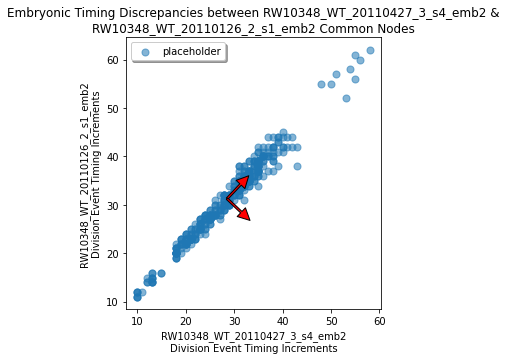

[[ 0.68755025  0.7261368 ]
 [ 0.7261368  -0.68755025]] [144.8604571    1.06126902] 
 1.0561217772595455


(None, 1.0561217772595455)

In [1551]:
dict_PCA_img(refnameset,refdictset,10,2),dict_PCA(refnameset,refdictset,10,2)

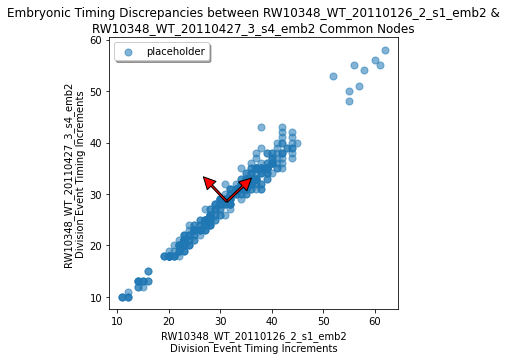

[[ 0.7261368   0.68755025]
 [-0.68755025  0.7261368 ]] [144.8604571    1.06126902] 
 0.9468605056083862


(None, 0.9468605056083862)

In [1552]:
dict_PCA_img(refnameset,refdictset,2,10),dict_PCA(refnameset,refdictset,2,10)

In [1553]:
b_mat = [];PCA_mat = [];cosine_mat = []
for n in range(0,len(refdictset)):
    b_row = [];PCA_row = [];cosine_row = []
    for m in range(0,len(refdictset)):
        b_row.append(branch_distance(refdictset[n],refdictset[m]))
        PCA_row.append(dict_PCA(refnameset,refdictset,n,m))
        cosine_row.append(cosine_pseudodistance(refdictset[n],refdictset[m]))
    b_mat.append(b_row)
    PCA_mat.append(PCA_row)
    cosine_mat.append(cosine_row)
b_mat = np.mat(b_mat);PCA_mat = np.mat(PCA_mat);cosine_mat = np.mat(cosine_mat)

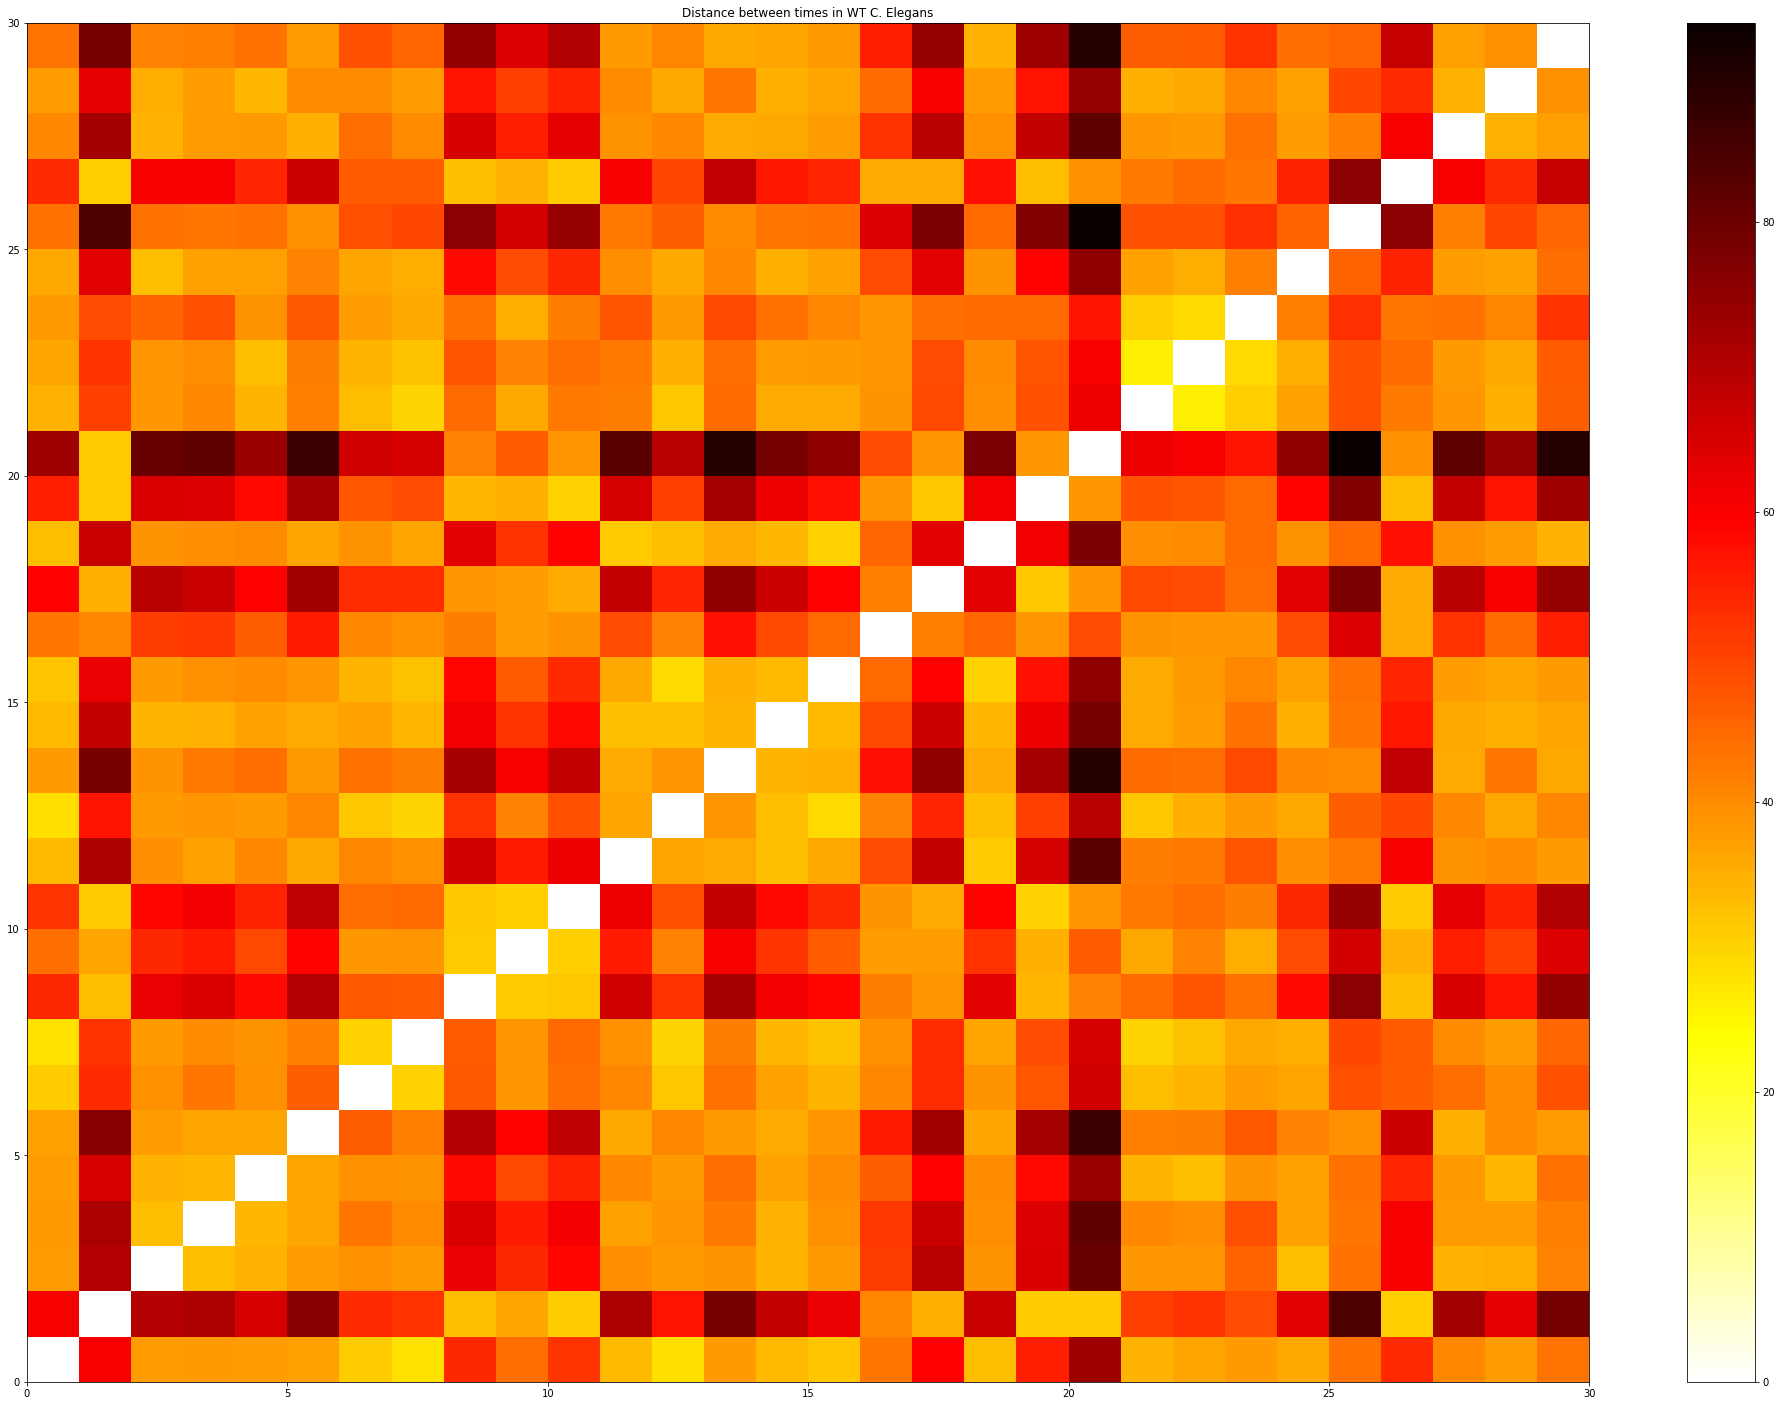

In [1554]:
plot_2_examples(['hot_r'],b_mat  )

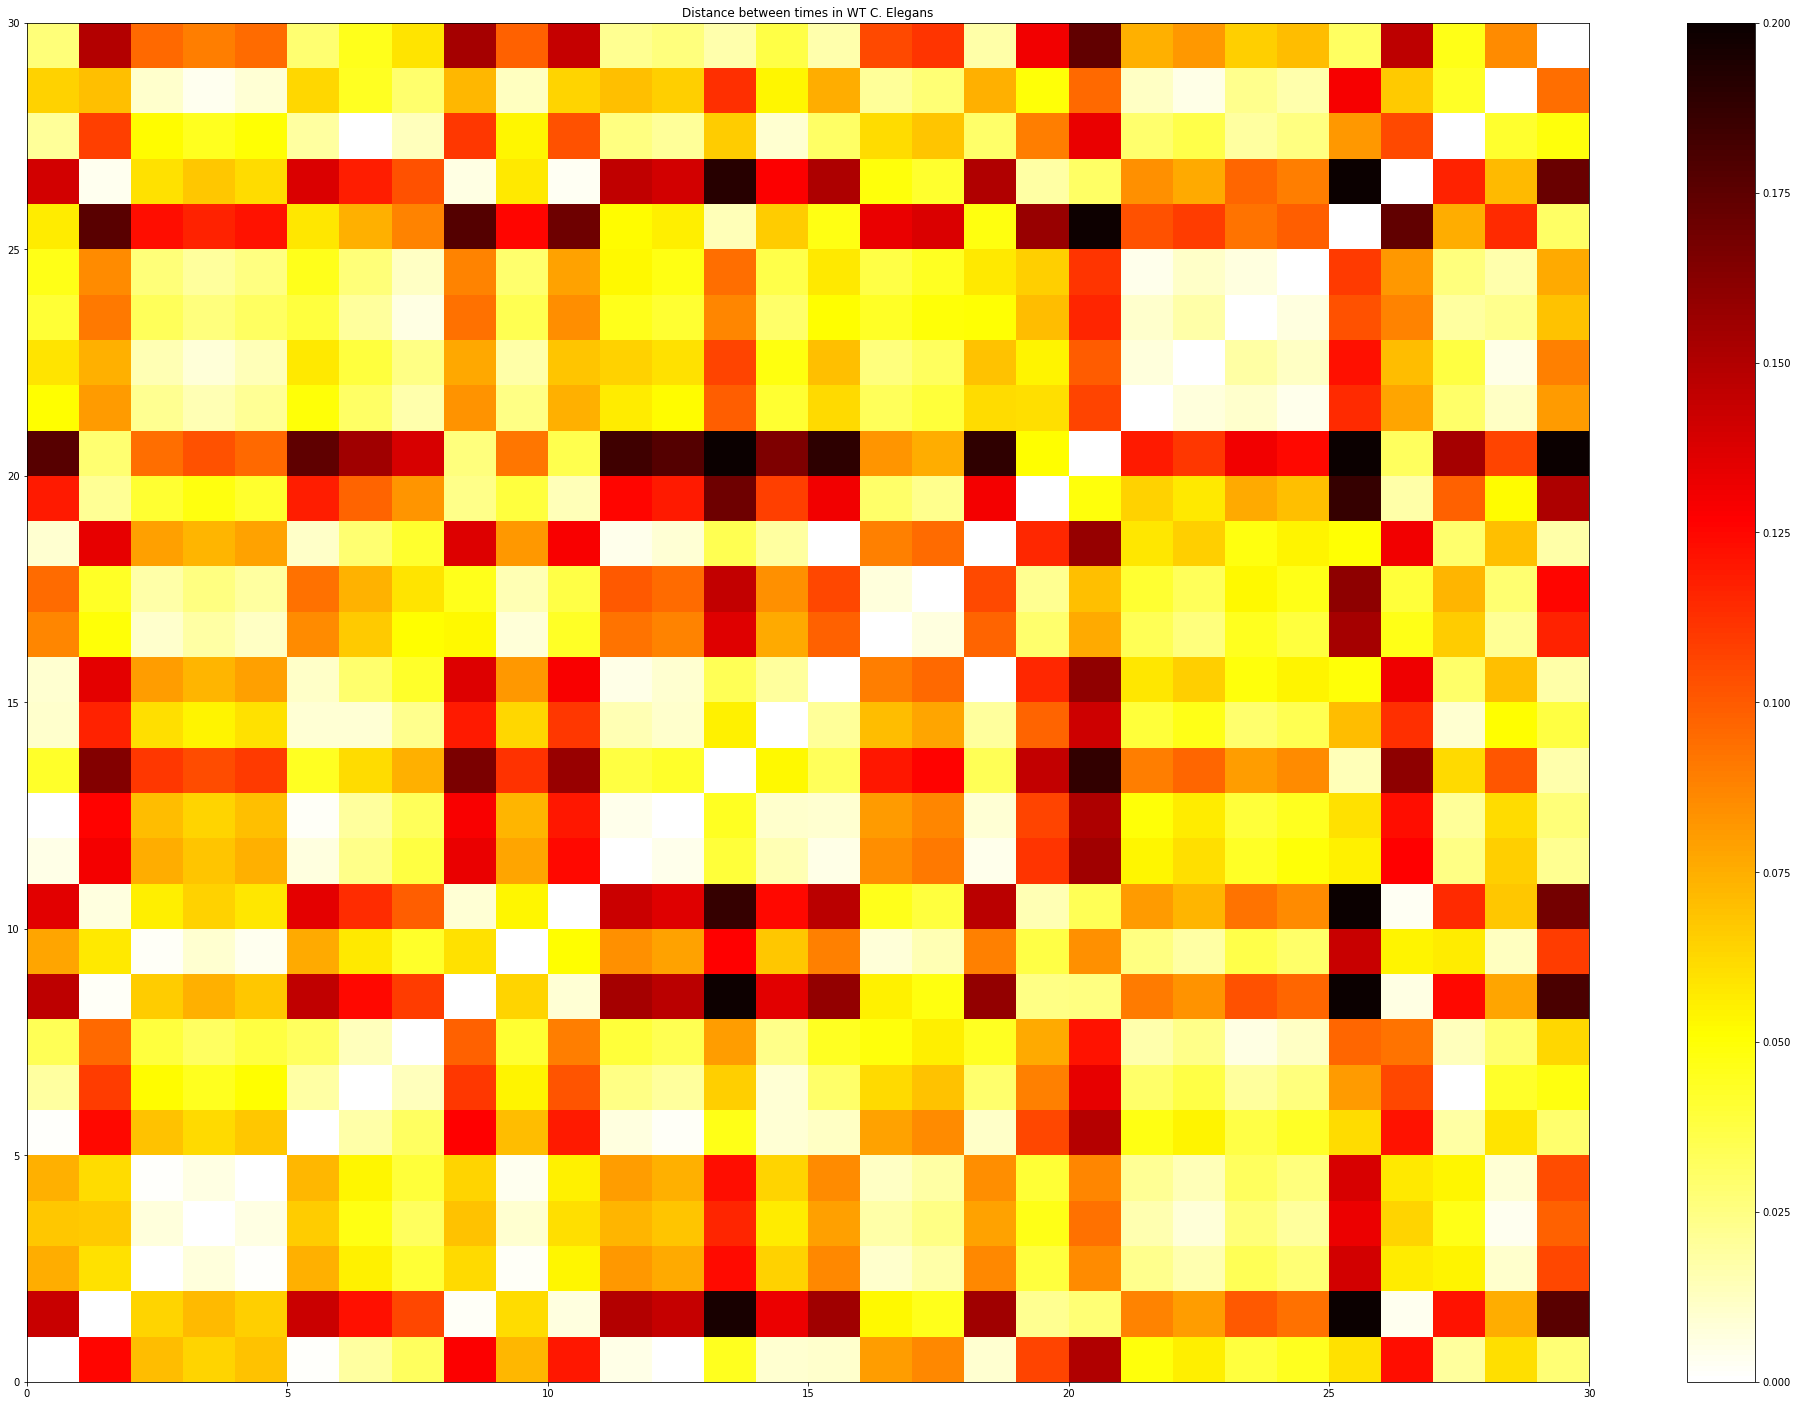

In [1555]:
plot_2_examples(['hot_r'],np.abs(PCA_mat-1))

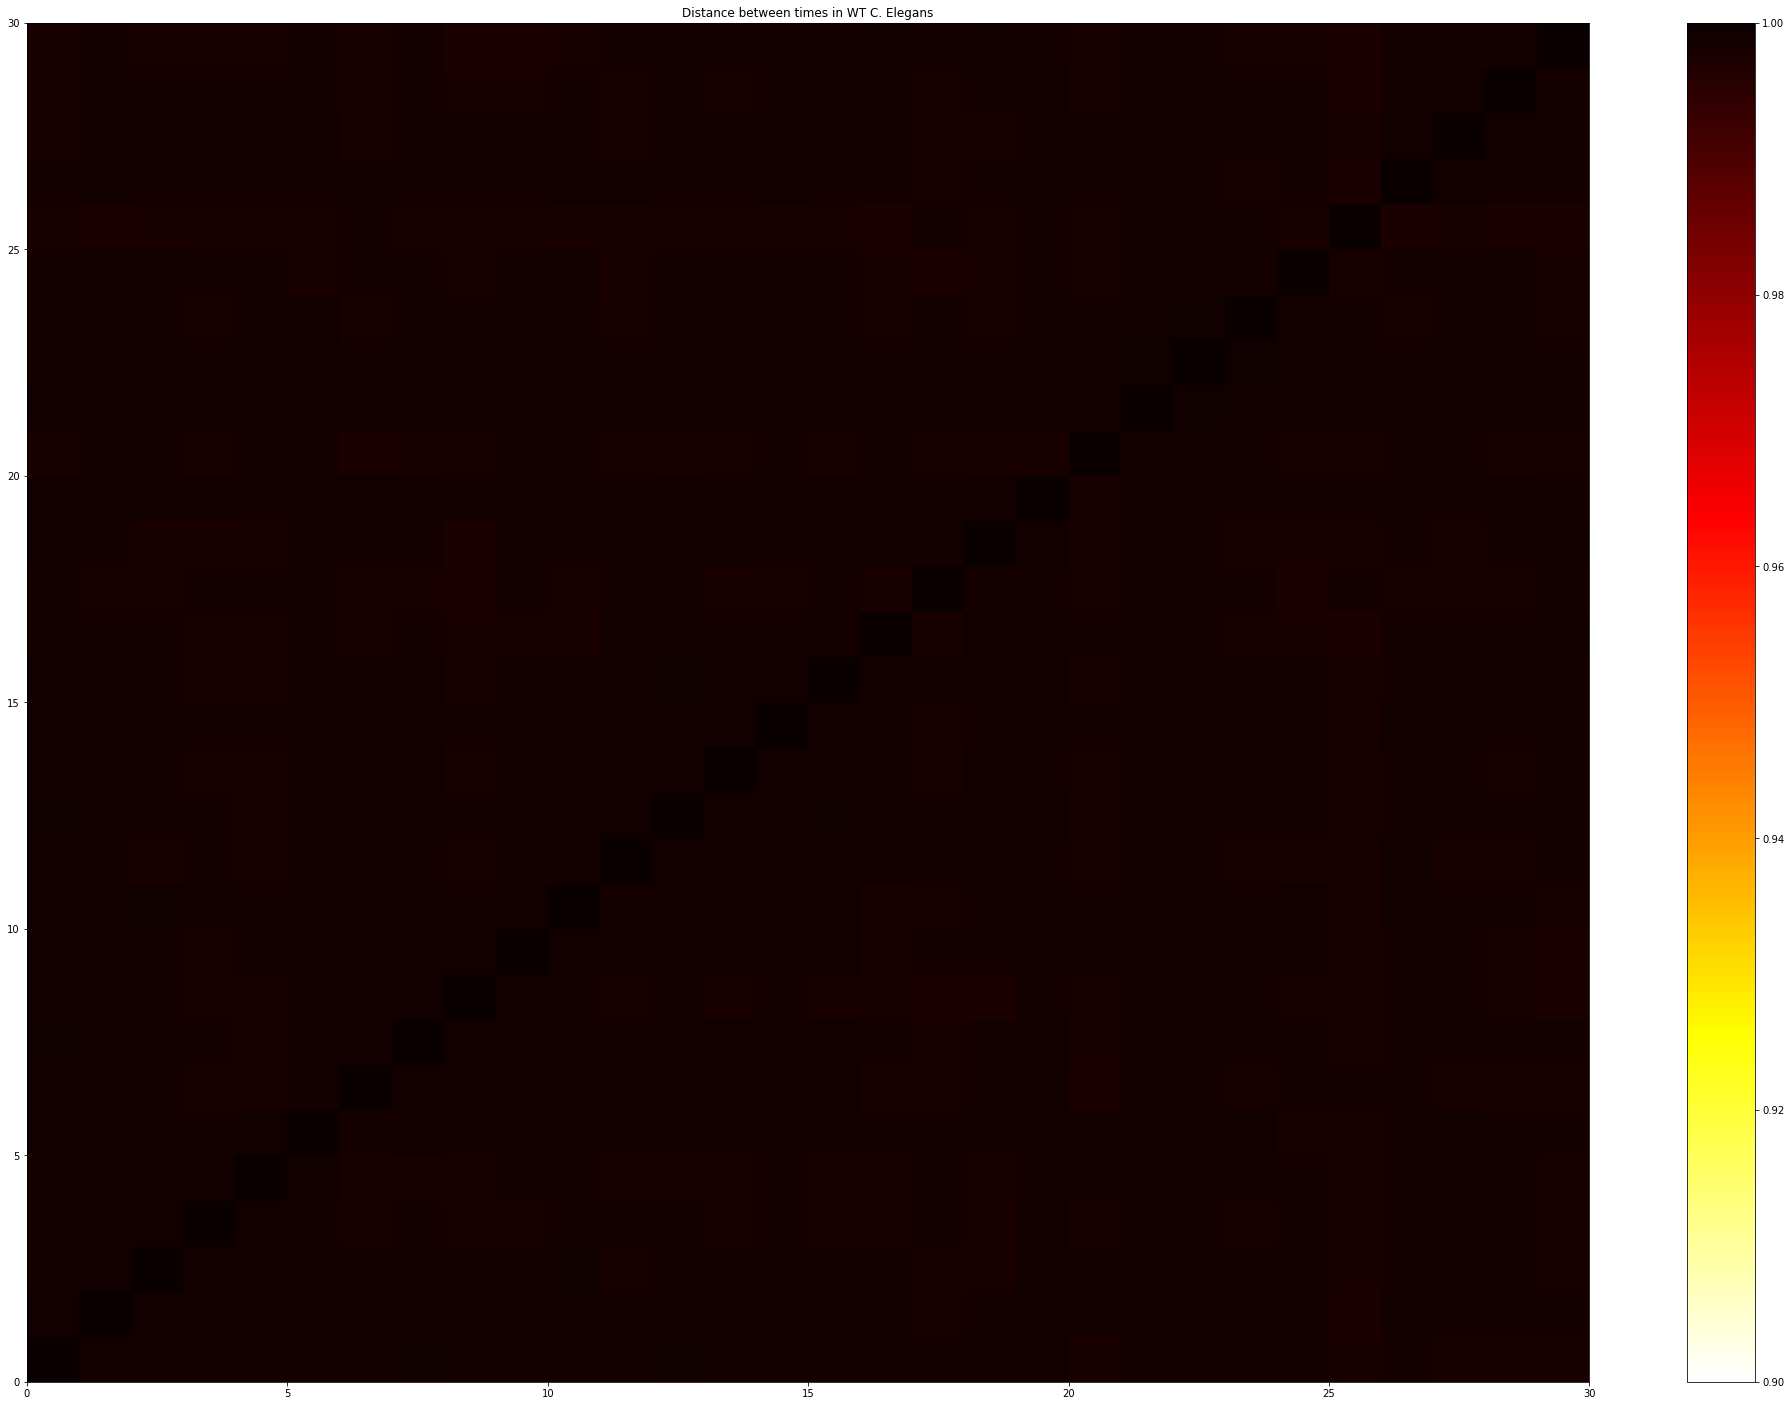

In [1556]:
plot_2_examples(['hot_r'], cosine_mat)

/tmp/ipykernel_1513471/814566297.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(np.mat(b_mat), 'average')


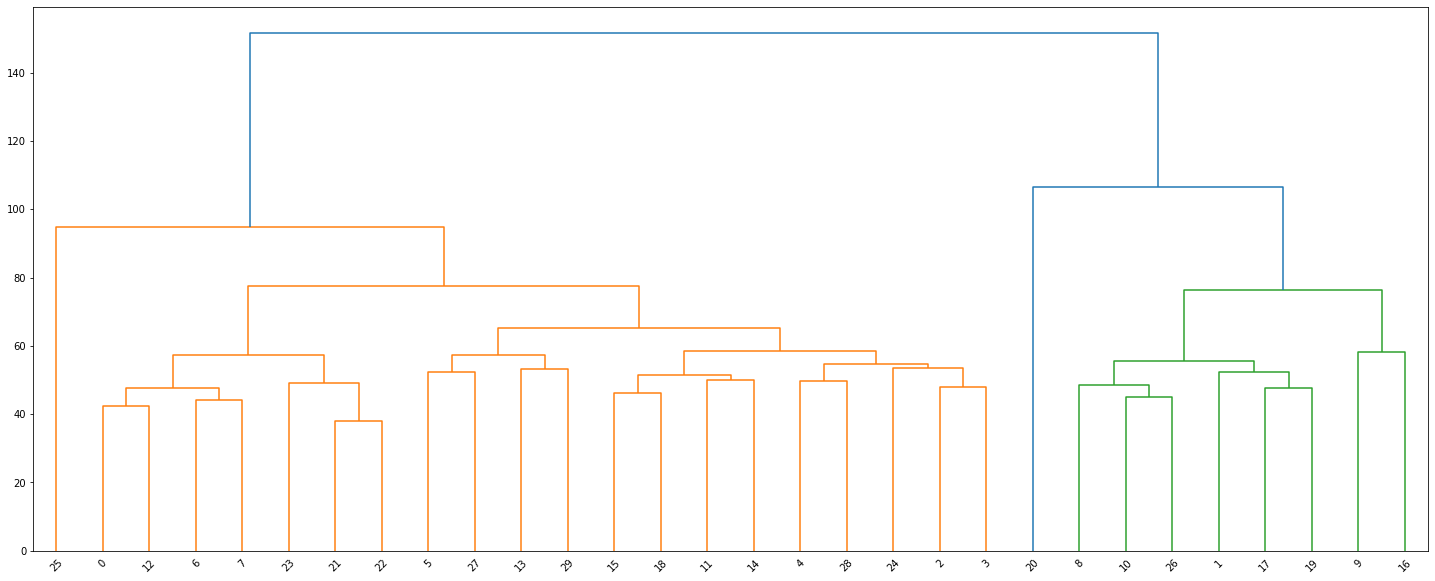

In [1557]:
Z = linkage(np.mat(b_mat), 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
b_mat_cluster = fcluster(Z, t=2, criterion='maxclust') 

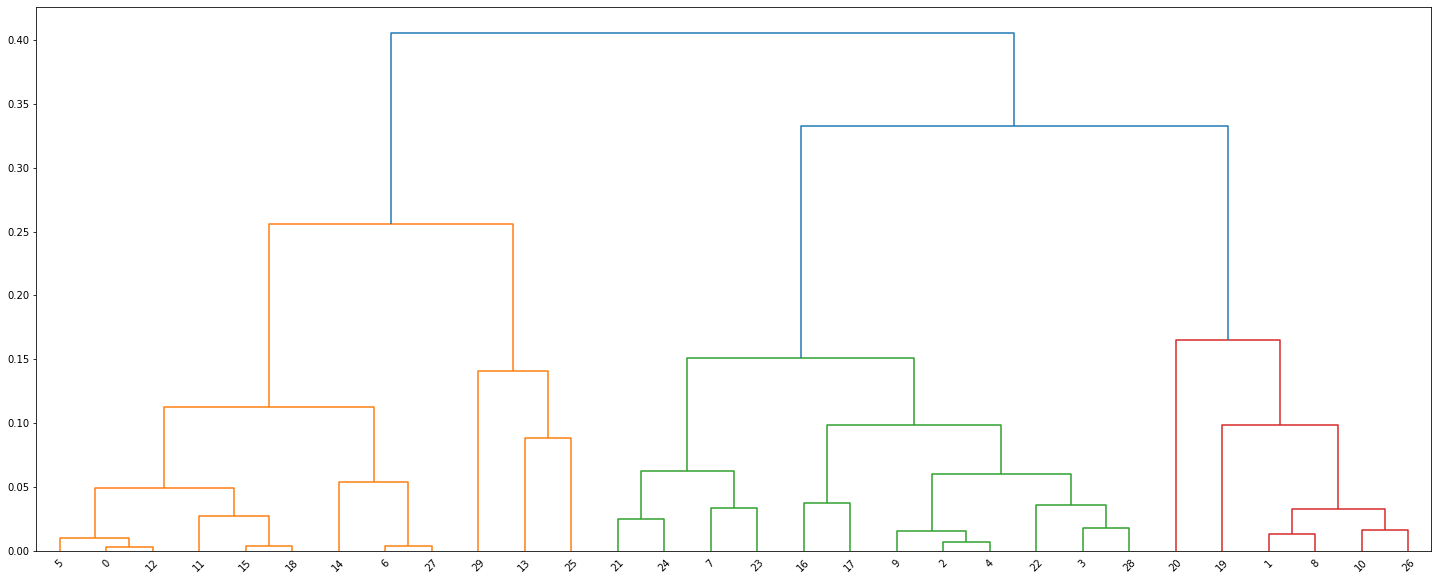

In [1558]:
Z = linkage(np.abs(PCA_mat-1).T, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
PCA_mat_cluster = fcluster(Z, t=2, criterion='maxclust') 

In [1559]:
np.abs(PCA_mat-1).sum(axis=0).argmin(),b_mat.sum(axis=0).argmin()

(21, 21)

In [1560]:
intscaledrefdictset = [];floatscaledrefdictset = []
for n in range(0,len(refdictset)):
    new_dict_int = dict()
    new_dict_float = dict()
    slope = dict_PCA(refnameset,refdictset,21,n)
    #print(dict_PCA(refnameset,refdictset,21,n))
    for m in refdictset[n]:
        #print(m,refdictset[n][m],refdictset[n][m]/slope)
        new_dict_int[m] = int(refdictset[n][m]/slope)+1
        new_dict_float[m] = refdictset[n][m]/slope
    intscaledrefdictset.append(new_dict_int);floatscaledrefdictset.append(new_dict_float)

In [1562]:
medsc_b_mat = [];medsc_PCA_mat = [];medsc_cosine_mat = []
for n in range(0,len(refdictset)):
    b_row = [];PCA_row = [];cosine_row = []
    for m in range(0,len(refdictset)):
        b_row.append(branch_distance(intscaledrefdictset[n],intscaledrefdictset[m]))
        PCA_row.append(dict_PCA(refnameset,intscaledrefdictset,n,m))
        cosine_row.append(cosine_pseudodistance(intscaledrefdictset[n],intscaledrefdictset[m]))
    medsc_b_mat.append(b_row)
    medsc_PCA_mat.append(PCA_row)
    medsc_cosine_mat.append(cosine_row)
medsc_b_mat = np.mat(medsc_b_mat);medsc_PCA_mat = np.mat(medsc_PCA_mat);medsc_cosine_mat = np.mat(medsc_cosine_mat)

In [1563]:
np.sum(b_mat),np.sum(medsc_b_mat)

(41081.49625408887, 36667.93312108481)

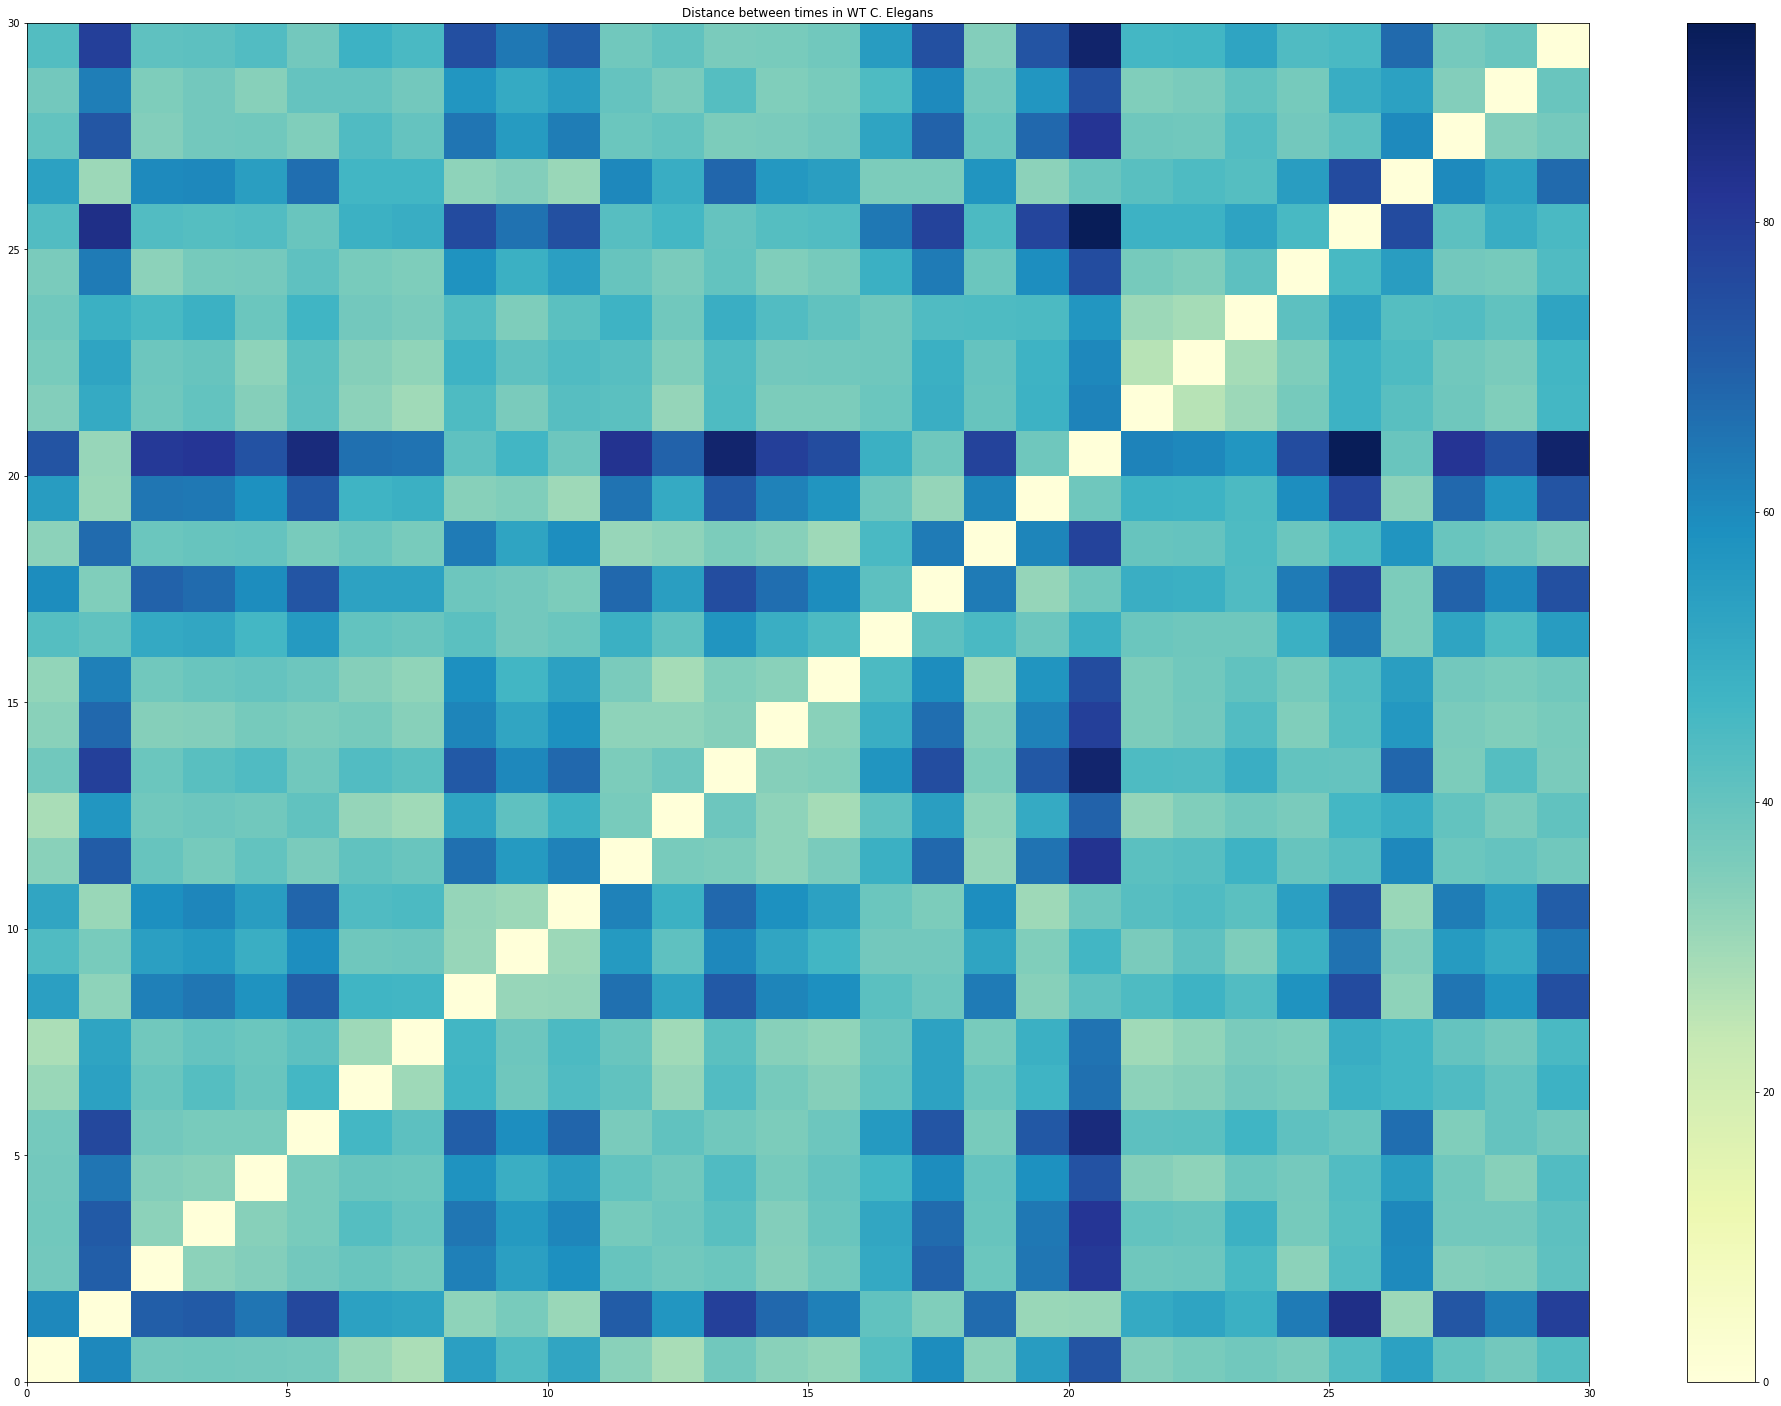

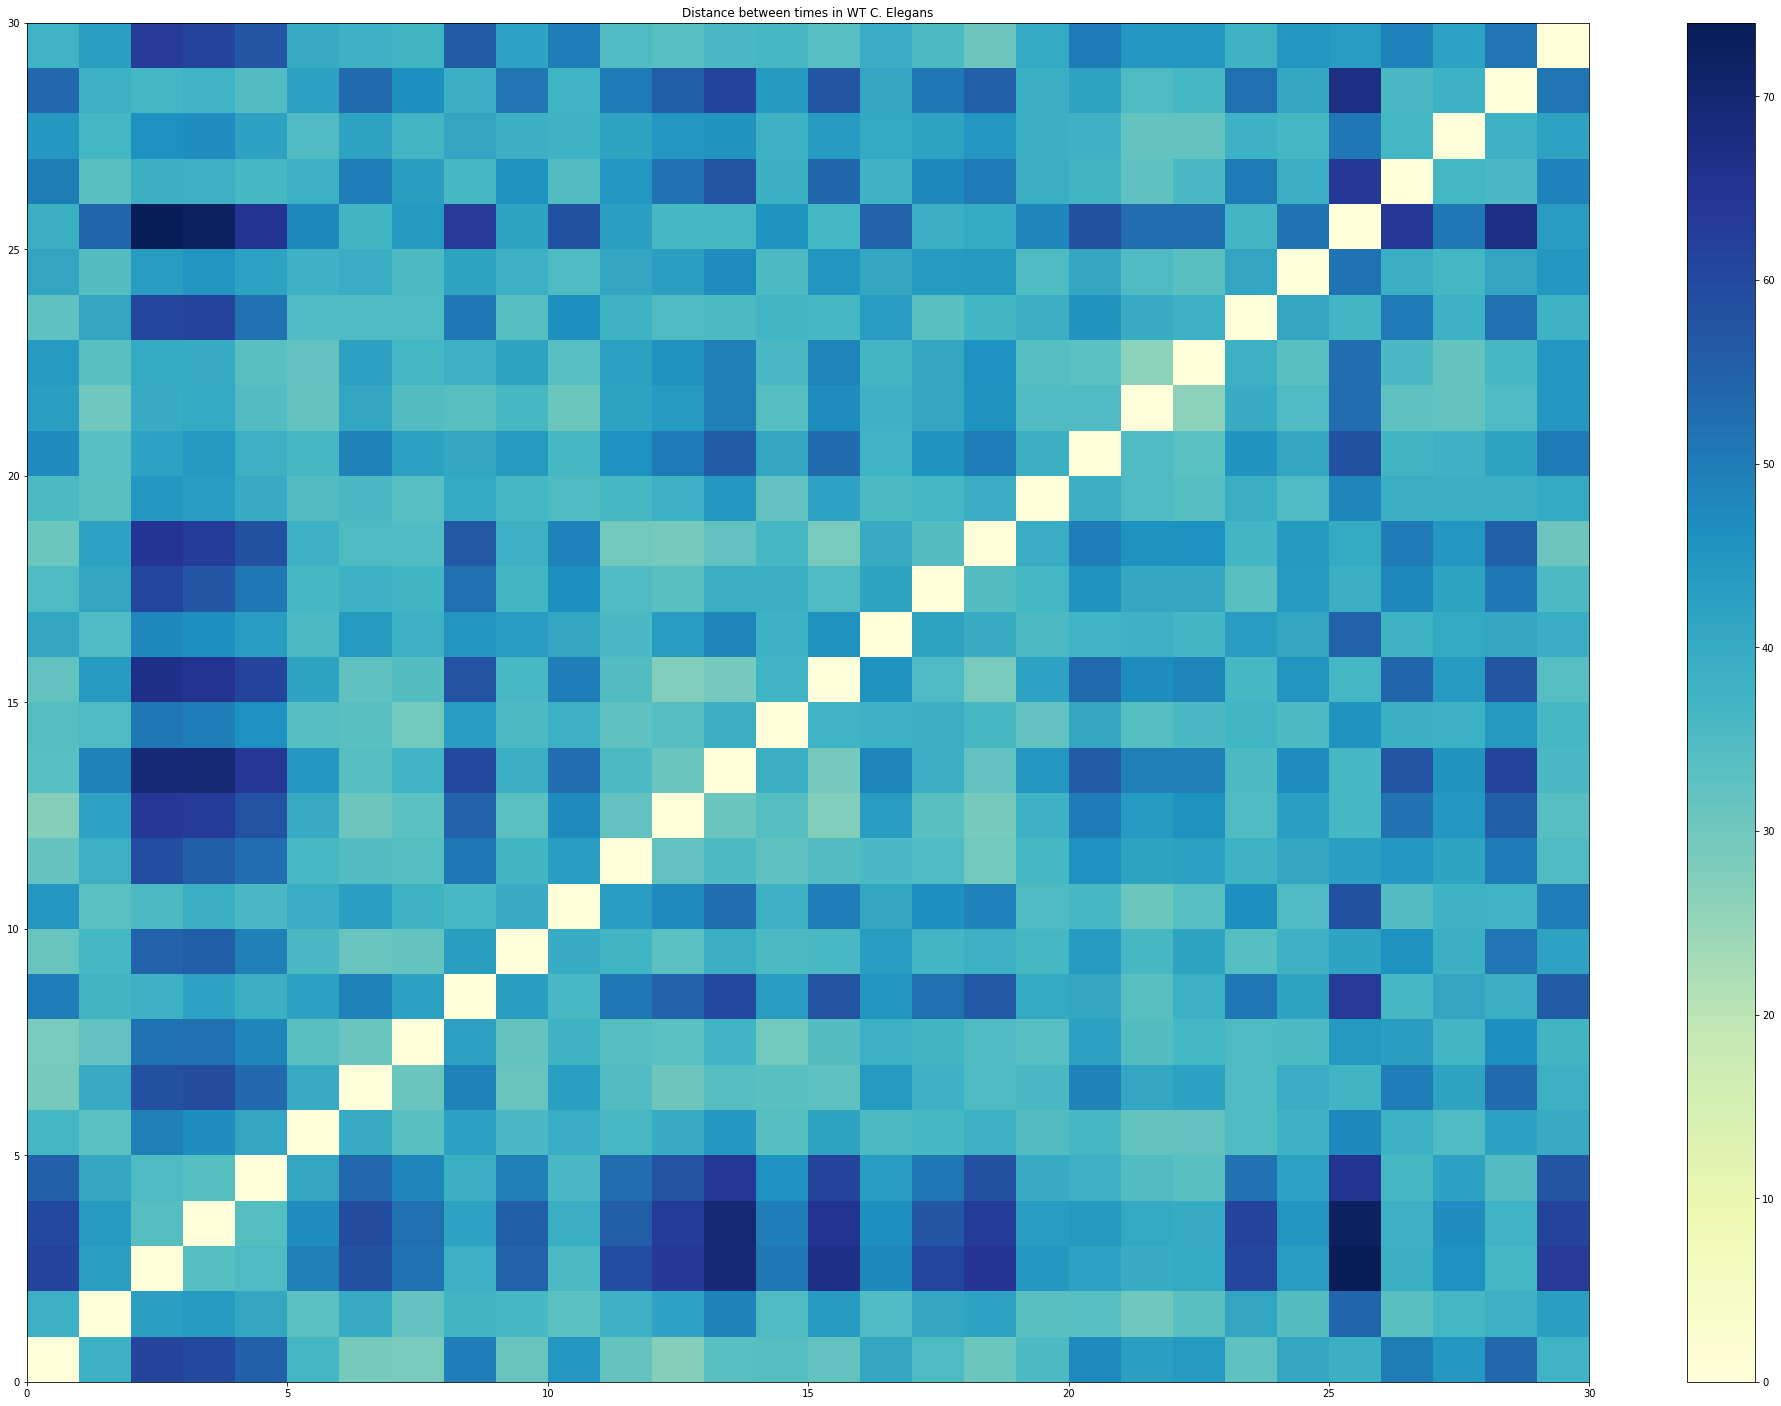

In [1564]:
plot_2_examples(["YlGnBu"],b_mat  );plot_2_examples(["YlGnBu"],medsc_b_mat)

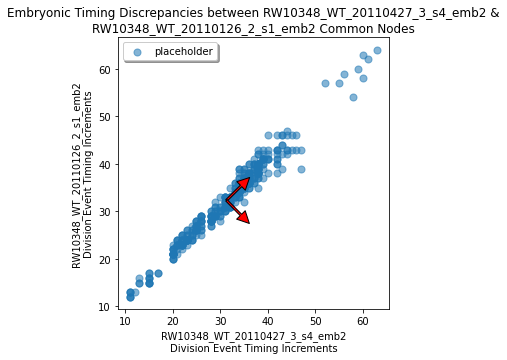

[[ 0.71119406  0.70299574]
 [ 0.70299574 -0.71119406]] [158.23440658   1.27591083] 
 0.9884724473087755


(None, 1.0561217772595455)

In [1565]:
dict_PCA_img(refnameset,intscaledrefdictset,10,2),dict_PCA(refnameset,refdictset,10,2)

In [1567]:
def node_comparison_trimmer(dict0,root_node):
    dict1 = dict(dict0)
    tip = dict()
    if root_node == 'EMS':
        root_node = 'Q'
        for n in [x for x in dict1 if re.search('E', x) or re.search('MS', x)]:
            if n[0] == 'E':
                dict1['Qp'+n[1:]] = dict1[n]
            elif n == 'MS' : dict1['Qp'] = dict1['MS']
            else:
                dict1['Qa'+n[2:]] = dict1[n]
    elif root_node == 'P2':
        root_node = 'Q'
        try:
            dict1['P3'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('C', x) or re.search('D', x)]:
            if n[0] == 'C':
                dict1['Qr'+n[1:]] = dict1[n]
            else:
                dict1['Qrr'+n[1:]] = dict1[n]
    elif root_node == 'P3':
        root_node = 'Q'
        try:
            dict1['P4'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('D', x)]:
            dict1['Qr'+n[1:]] = dict1[n]
    for n in [x for x in dict1 if re.search(root_node, x)]: 
        m = n.replace('r', "p").replace('v', "p")
        m = m.replace('d', "a").replace('l', "a")
        m = m[len(root_node):]
        tip[m] = dict1[n]
    return tip

#TROUBLESHOOT

In [1569]:
'''for n in root_cells:
    for m in range(0,30):
        try:
            refdictset[m][n]
        except:
            print(m,n)'''
#This script finds inconsistencies within the presence of various cells in the given embryos 
#if run, it shows the founder cells that do not exist in the reference nodes
#none of the 30 embryos have nodes AB, nodes P1 and P4 are inconsistently present

'for n in root_cells:\n    for m in range(0,30):\n        try:\n            refdictset[m][n]\n        except:\n            print(m,n)'

In [1570]:
root_cells_comp = [ 'ABa', 'ABp', 'ABal', 'ABar', 'ABpl', 'ABpr', 'ABala', 'ABalp', 'ABara', 'ABarp', 'ABpla', 'ABplp', 'ABpra', 'ABprp', 'EMS', 'P2', 'MS', 'E', 'C', 'P3', 'D', ]
inlier_ref = [ 0,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 28, 29]

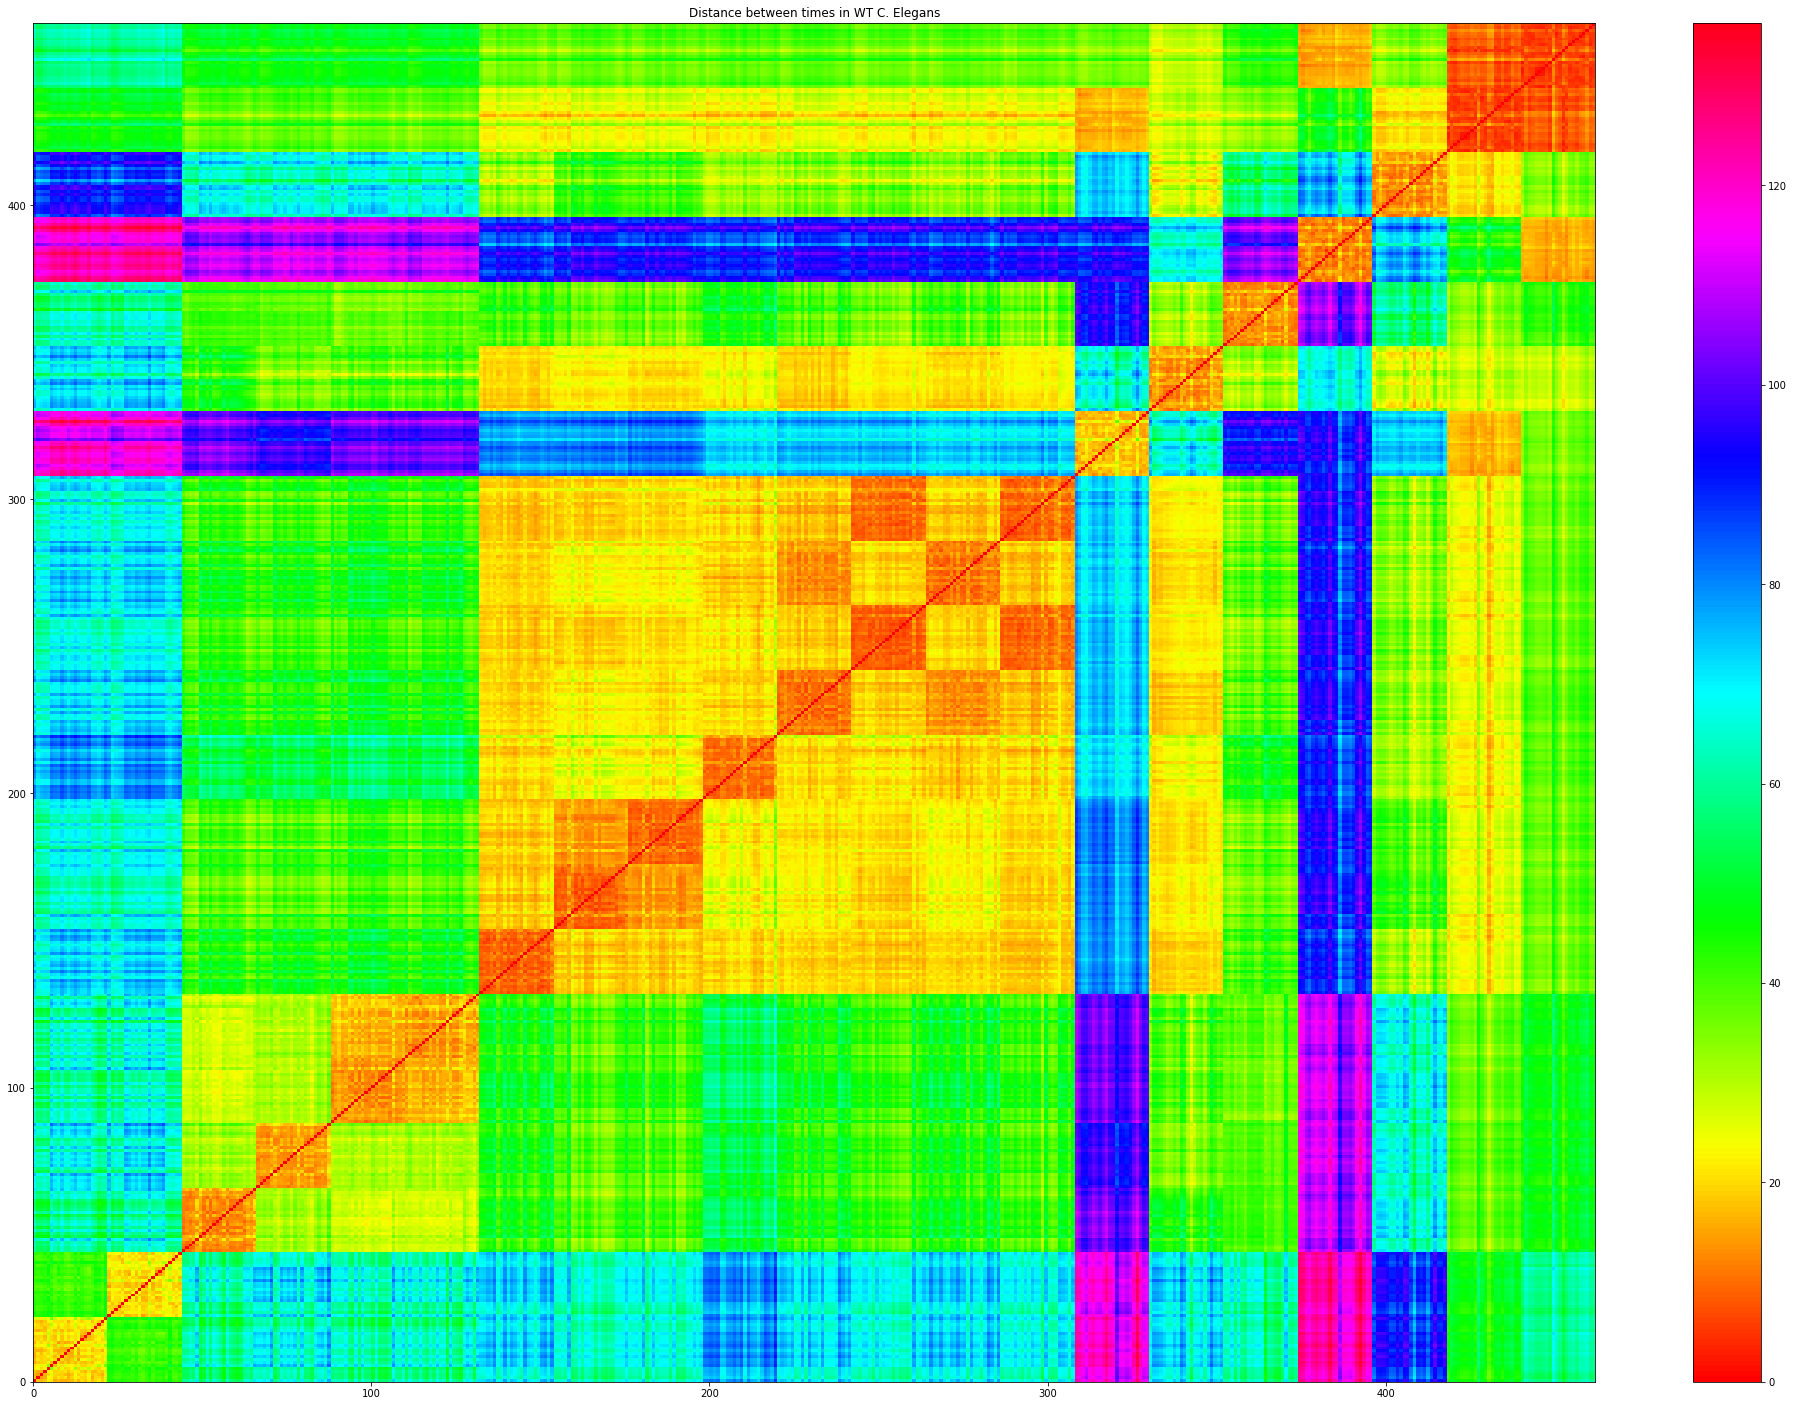

In [1571]:
b_mat = []
for n in root_cells_comp:
    for m in inlier_ref:
        branches = []
        for a in root_cells_comp:
            for b in inlier_ref:
                branches.append(branch_distance(node_comparison_trimmer(fulldictset[m],n),node_comparison_trimmer(fulldictset[b],a)))
        b_mat.append(branches)
b_mat = np.mat(b_mat)        
#plot_2_examples(['viridis'],b_mat)
plot_2_examples(['hsv'],b_mat)

In [1572]:
b_mat = np.mat(b_mat); np.seterr(divide='ignore', invalid='ignore')
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

In [1573]:
def novel_two_sample_permutation_test(list1,list2,its):
    ref_list = sorted([list1,list2], key = len)
    list1 = ref_list[0];list2 = ref_list[1]
    len1 = len(list1);len2 = len(list2)
    list1,list2 = np.array(list1),np.array(list2)
    reference_mean = np.mean(list1) - np.mean(list2)
    hist_list = []
    for n in range(0,its):
        pop15 = random.sample(range(0, len2), len1)
        full_list = np.concatenate((list1,list2[pop15]), axis=None)
        pop1 = random.sample(range(0, len(full_list)), len1);
        pop2 = random.sample(range(0, len(full_list)), len1)
        resamp_mean = np.mean(full_list[pop1]) - np.mean(full_list[pop2])
        hist_list.append(resamp_mean)
    #plt.hist(hist_list)
    hist_list = np.array(hist_list)
    if reference_mean < 0:
        p = np.sum(hist_list <= reference_mean)/its
    else:
        p = np.sum(hist_list >= reference_mean)/its
    return p
    #Its one sided because the distances between ingroup members is always going to be smaller.
    #rewrite to check for making sure the differences is always one sided such that RNAi distance mean is 
    #larger than the ingroup distance mean
        

In [1574]:
b_mat = np.mat(b_mat) 
n = 13;m = 11
scale = len(inlier_ref)
go = self_comp(np.mat(b_mat[n*scale:(n+1)*scale,n*scale:(n+1)*scale])).tolist()
go2 = np.mat(b_mat[n*scale:(n+1)*scale,m*scale:(m+1)*scale]).flatten()[0]
go2 = go2[go2 != 0]
go2 = go2.tolist()[0]
print(novel_two_sample_permutation_test(go2,go,5000))
t,p = ttest_ind(go, go2, equal_var=False)
print(t,p)
t,p = stats.brunnermunzel(go, go2)
print(t,p)

0.1816
0.7229288756214408 0.47016433321784135
-0.02379872972860727 0.9810260801261453


In [1575]:
scale = len(inlier_ref);b_mat = np.mat(b_mat)
resample_mat = [];ttest_mat = [];bm_mat = []
for n in range(0,scale-1):
    resample_row = [];ttest_row = [];bm_row = []
    nn = self_comp(np.mat(b_mat[n*scale:(n+1)*scale,n*scale:(n+1)*scale])).tolist()
    for m in range(0,scale-1):
        go2 = np.mat(b_mat[n*scale:(n+1)*scale,m*scale:(m+1)*scale]).flatten()[0]
        go2 = go2[go2 != 0]
        mm = go2.tolist()[0]
        ntsp = novel_two_sample_permutation_test(nn,mm,50)
        if ntsp > 0.01:
            if n != m:
                print('WT/WT branch',root_cells_comp[n],'WT/WT branch',root_cells_comp[n],root_cells_comp[m])
            #print(ntsp)
        resample_row.append(ntsp)
        t,p = ttest_ind(nn,mm, equal_var=False)
        ttest_row.append(p)
        t2,p2 = stats.brunnermunzel(nn,mm)
        bm_row.append(p2)
    resample_mat.append(resample_row)
    ttest_mat.append(ttest_row)
    bm_mat.append(bm_row)

resample_mat = np.mat(resample_mat);ttest_mat = np.mat(ttest_mat);bm_mat = np.mat(bm_mat)
bm_mat = np.nan_to_num(bm_mat)
        #print(n,m,nn[0:2],mm[0:2])

WT/WT branch ABprp WT/WT branch ABprp ABplp


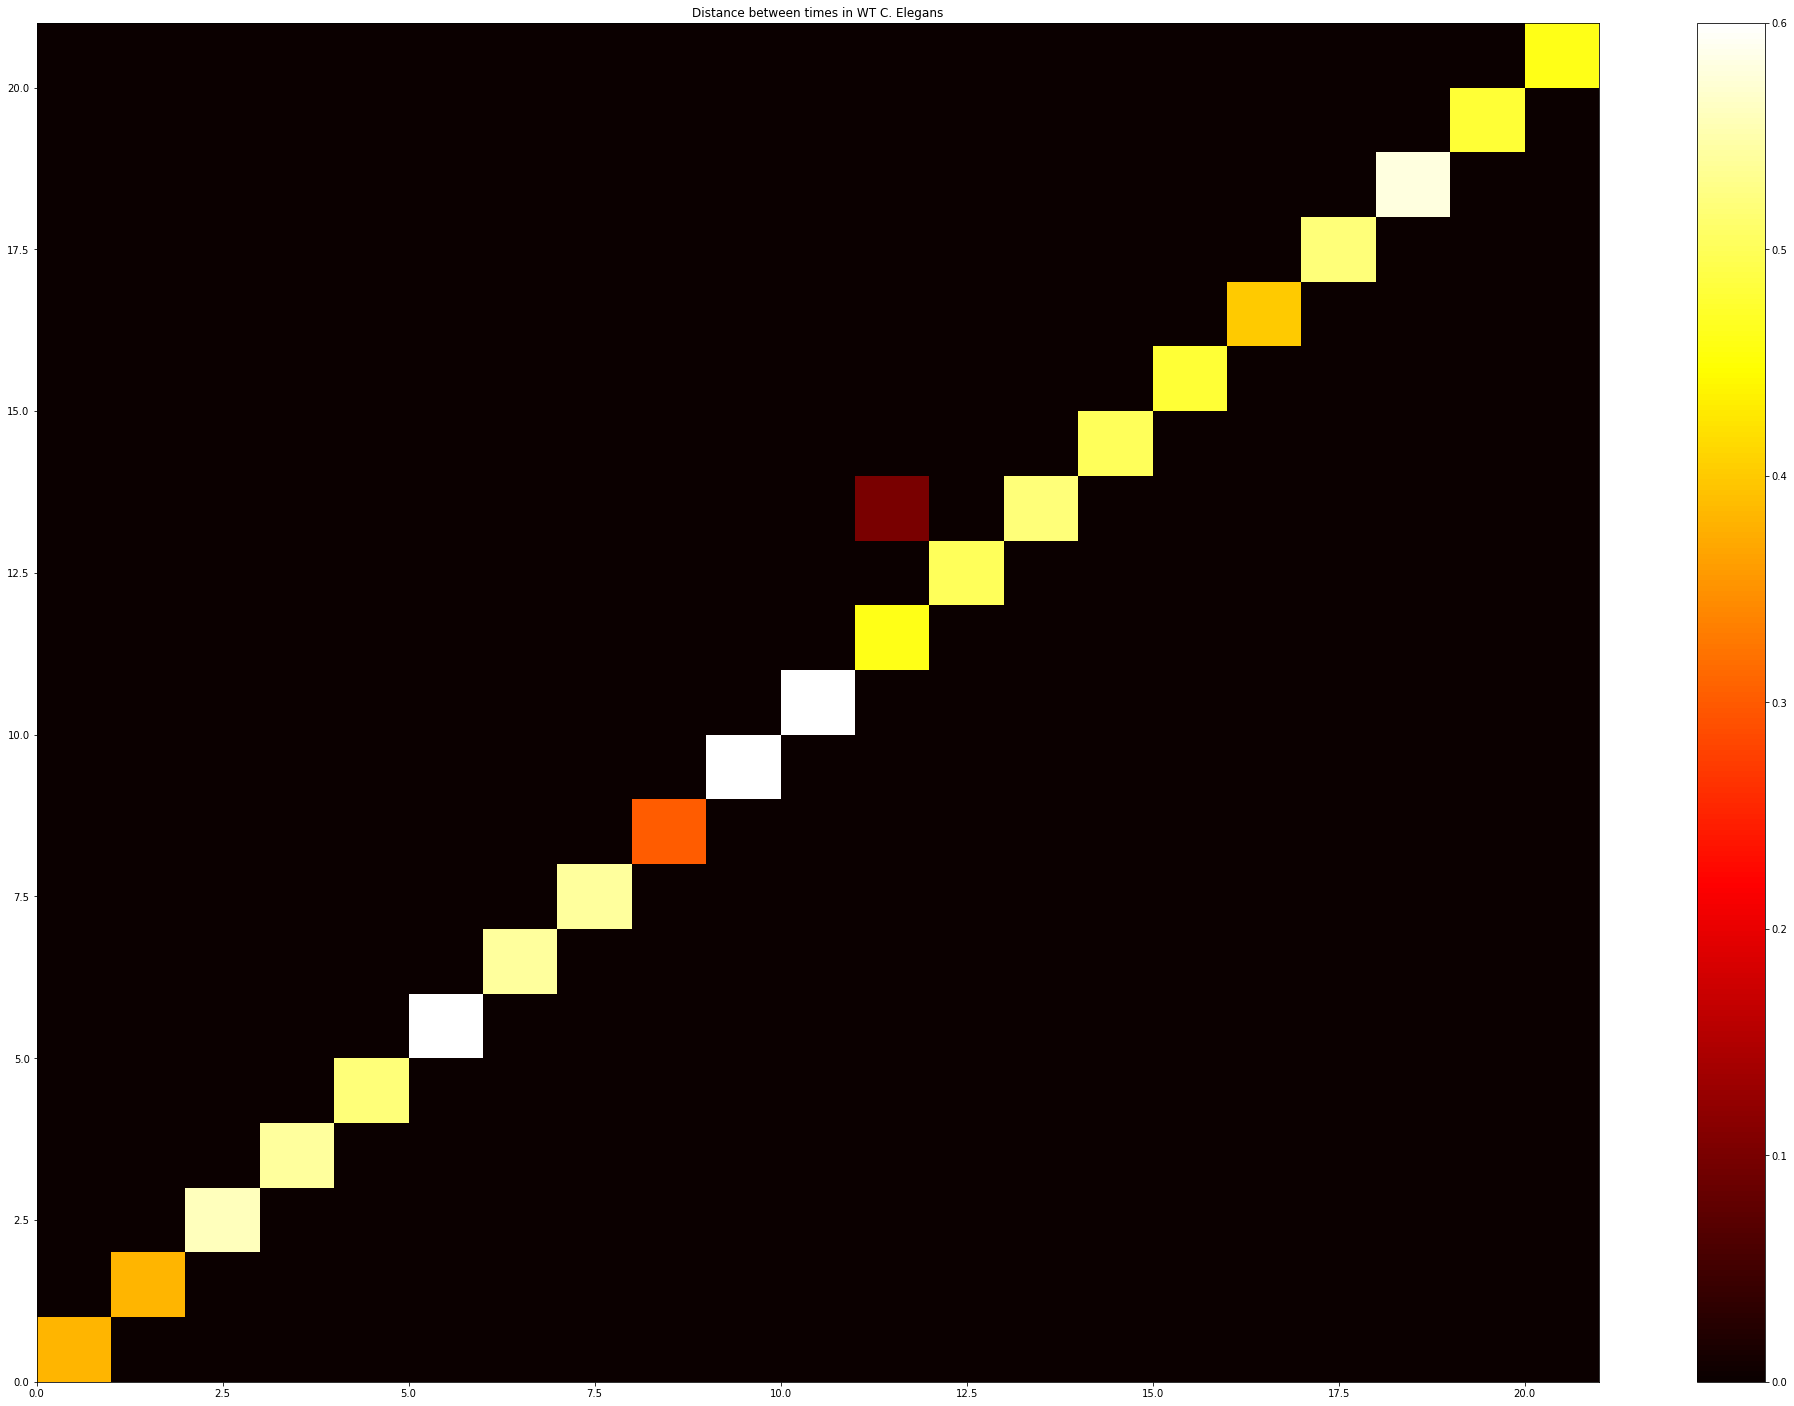

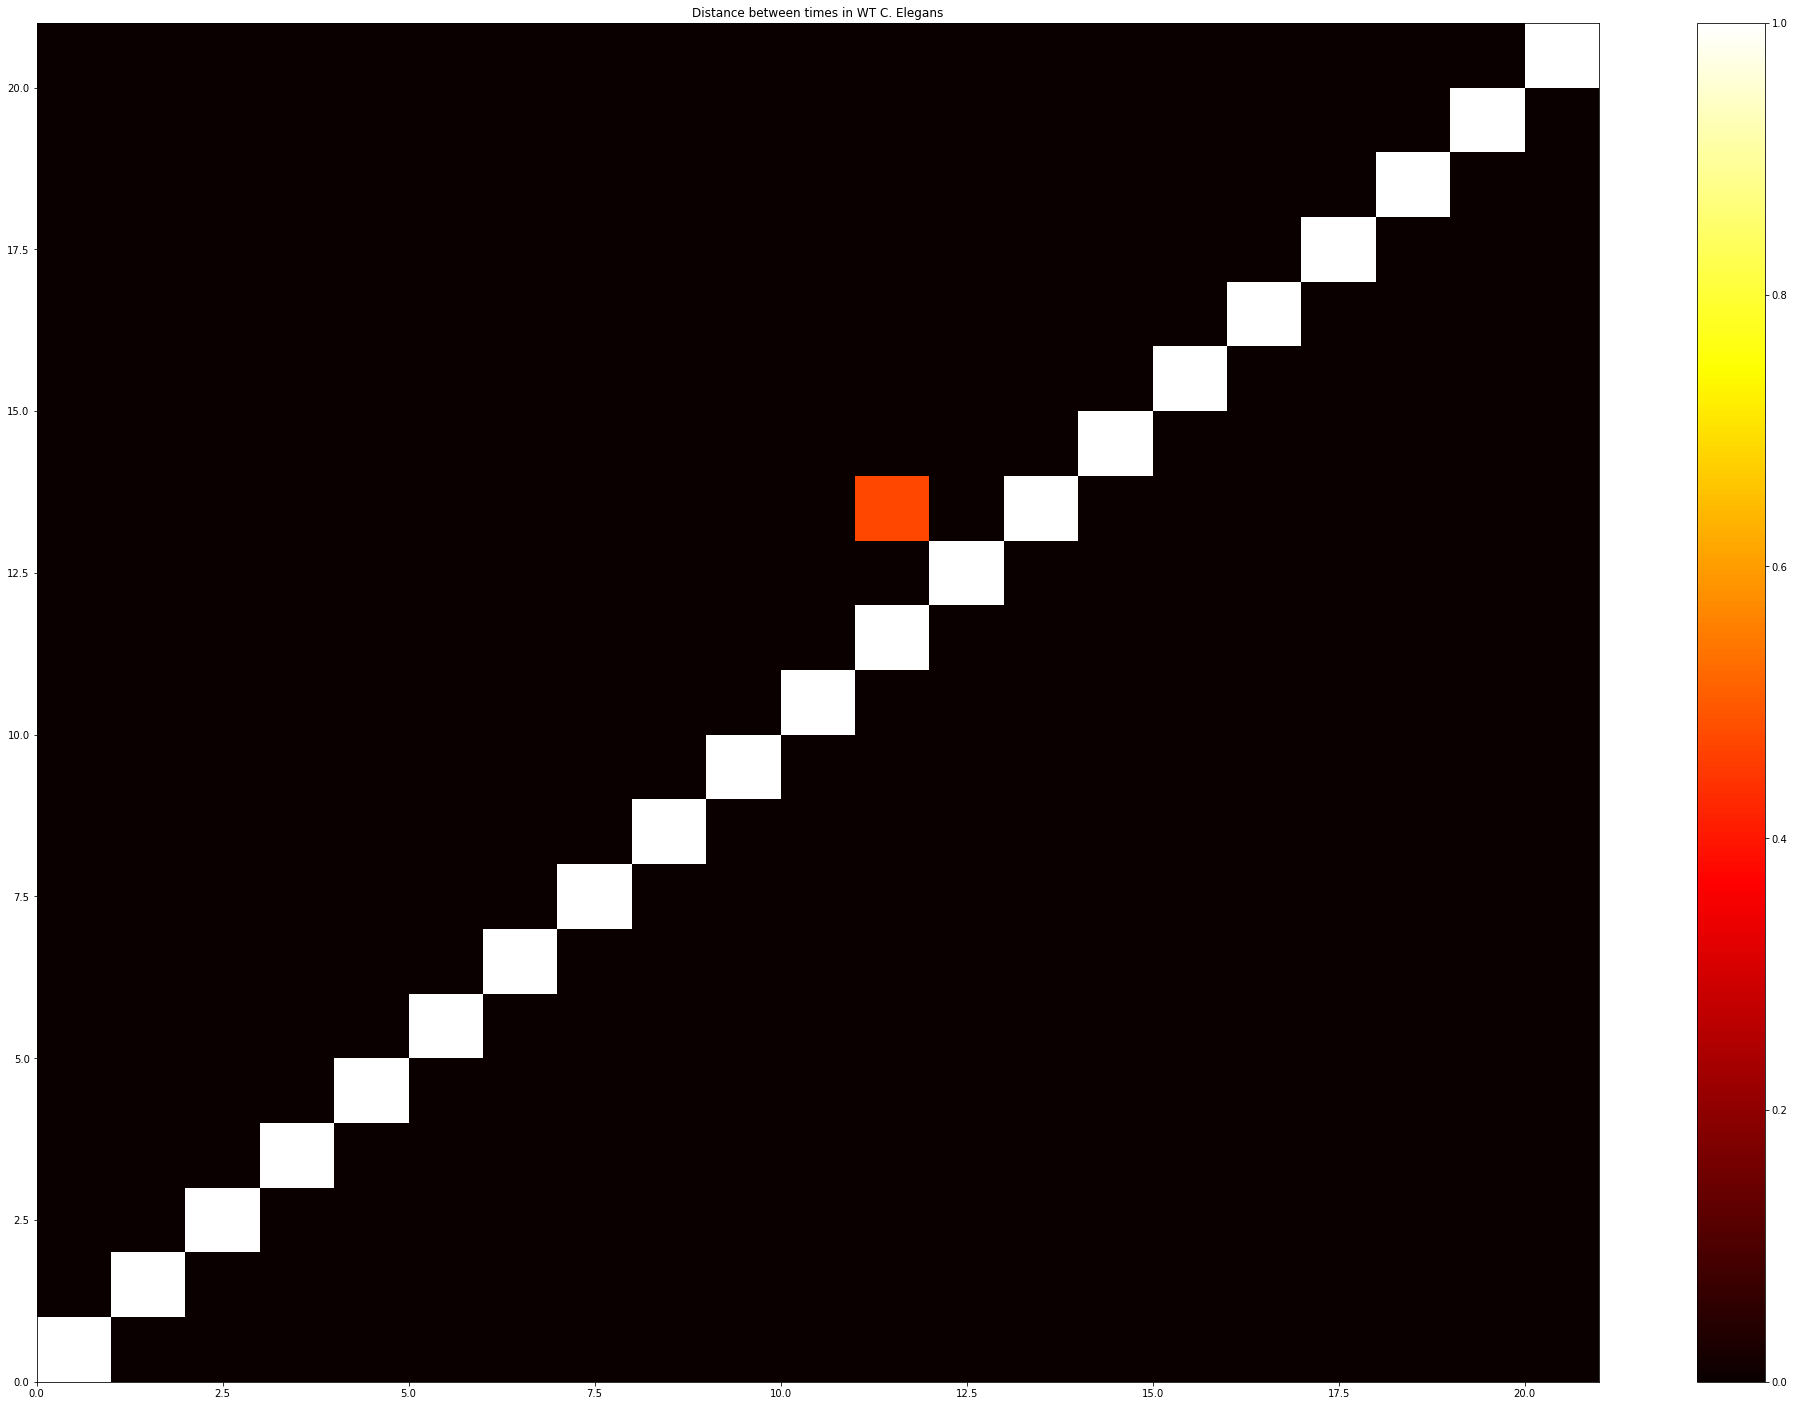

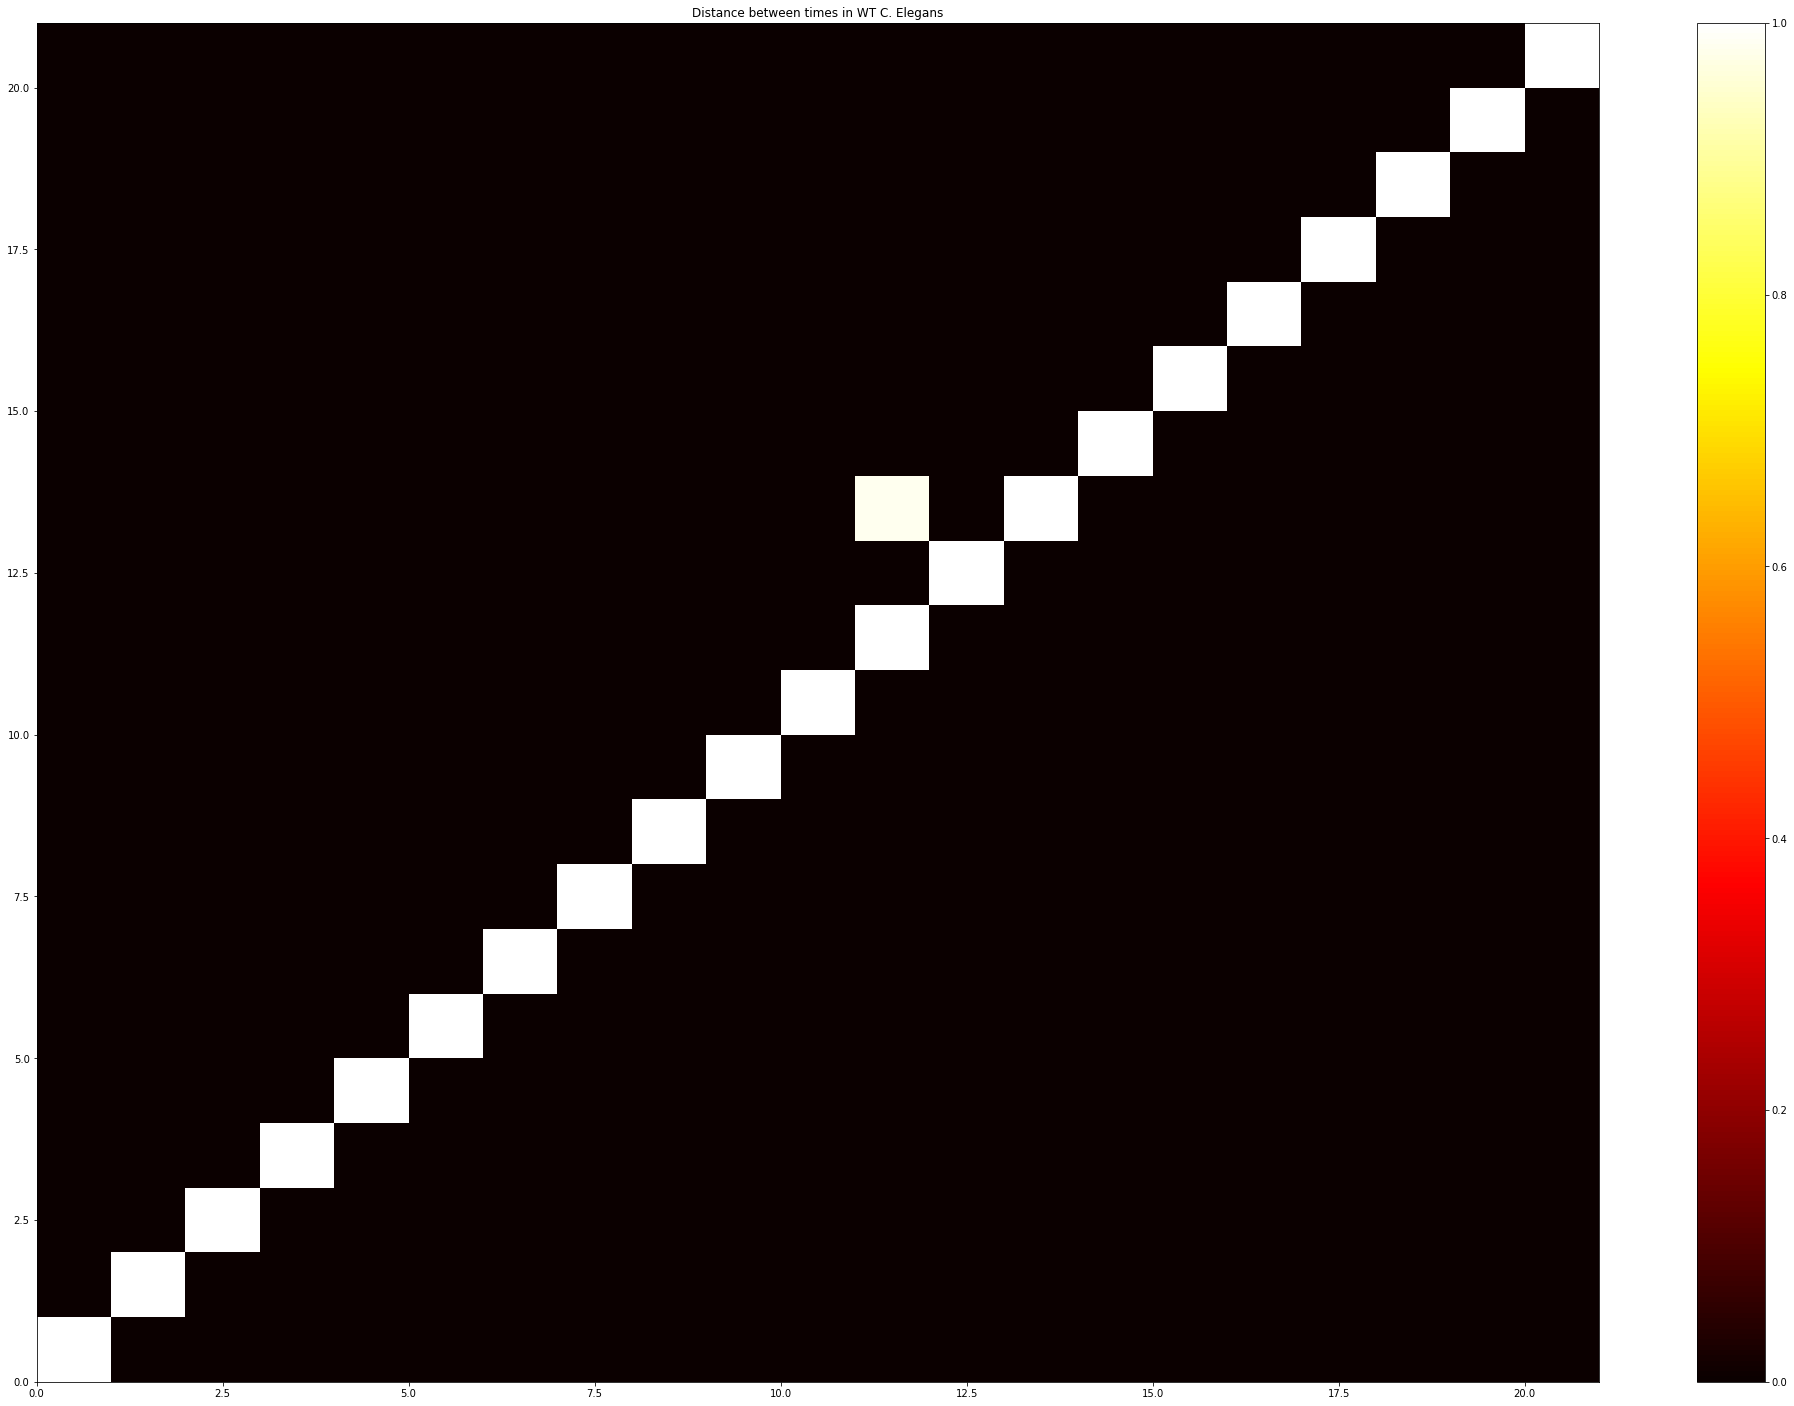

In [1576]:
plot_2_examples(['hot'],resample_mat);plot_2_examples(['hot'],ttest_mat);plot_2_examples(['hot'],bm_mat)

In [1577]:
#These 3 graphs say that WT ABprp against RNAI 
print(ttest_mat[13,11])
root_cells_comp[11],root_cells_comp[13]

0.47016433321784135


('ABplp', 'ABprp')

In [1578]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

In [1579]:
#plot_2_examples(["YlGnBu"],p_val_mat)
print(root_cells_comp)

['ABa', 'ABp', 'ABal', 'ABar', 'ABpl', 'ABpr', 'ABala', 'ABalp', 'ABara', 'ABarp', 'ABpla', 'ABplp', 'ABpra', 'ABprp', 'EMS', 'P2', 'MS', 'E', 'C', 'P3', 'D']


In [1584]:
jaccard_of_selfsubtrees = []
for n in root_cells_comp:
    for m in root_cells_comp[0:root_cells_comp.index(n)]:
        if n == m: continue
        cell_branches = [];cell_jaccard = []
        for a in inlier_ref:
            for b in inlier_ref:
                if a != b:
                    cell_jaccard.append(jaccard_distance(node_comparison_trimmer(fulldictset[a],n),node_comparison_trimmer(fulldictset[b],m)))
        print(n,m,np.mean(cell_jaccard))

In [1585]:
RNAi_size_assignments = dict()
RNAi_name_array = []
for n in range(0,len(nameset)):
    pad = nameset[n].split('/')[-1][:-14]
    RNAi_name_array.append(pad)
    try:
        z = RNAi_size_assignments[pad]
        z.append(n)
    except:
        z = list()
        z.append(n)
        RNAi_size_assignments[pad] = z
        
RNAi_name_array = np.array(RNAi_name_array)
qf = pd.read_csv('Undefined_trans.csv', header=None)
useit = list(qf.iloc[0])[0]
qf = pd.read_csv('Undefined_trans.csv')
Undefined_trans = dict()
for n in range(0,len(qf)):
    cells_of_interest = set(qf.iloc[n,1:])
    try:
        cells_of_interest.remove(useit)
    except:
        pass
    protein_tag = (qf.iloc[n,0].replace("'", "")).replace(",", "")
    
    cells_of_interest = sorted(list(cells_of_interest))
    print(protein_tag, cells_of_interest )
    Undefined_trans[protein_tag] = cells_of_interest
    embryos_of_interest = np.where(RNAi_name_array == protein_tag)[0]

ABI-1 ['ABpra']
AMA-1 ['ABalp', 'ABar', 'ABp', 'C', 'EMS']
AOS-1 ['ABala', 'ABpla']
APR-1 ['ABalp', 'ABar', 'ABplp']
APX-1 []
ARX-2 ['ABpl']
ATX-2 ['ABalp', 'C']
BUB-1 ['ABal', 'ABara', 'ABprp', 'C']
C01A2.5 ['ABalp', 'ABar', 'ABprp', 'E']
C01F1.1 []
C02B10.5 ['ABara', 'ABp']
C06A5.1 ['ABalp', 'ABar', 'ABpl', 'ABprp', 'EMS']
C07A9.2 ['ABarp', 'ABplp', 'C', 'MS']
C08B11.3 ['ABpla']
C49H3.8 ['ABalp', 'ABara', 'ABplp', 'ABpr', 'EMS']
C50F2.3 ['ABalp', 'ABar', 'ABp', 'C']
C55A6.9 ['E']
CACN-1 ['AB', 'C', 'EMS']
CAMT-1 ['ABal', 'ABpl', 'ABprp', 'MS']
CBP-1 ['AB', 'C', 'EMS']
CDC-25.1 []
CDC-37 ['ABar', 'ABarp', 'ABp', 'ABplp', 'C']
CDK-7 ['AB', 'C', 'EMS']
CDK-9 ['ABalp', 'ABar', 'ABp']
CDT-1 ['ABarp', 'ABp']
CEH-24 ['ABpra', 'ABprp', 'C', 'EMS']
CHAF-2 ['ABalp', 'ABara', 'ABp', 'C']
CHC-1 ['ABara', 'ABprp']
CHK-1 ['ABara', 'ABpla', 'ABprp', 'EMS']
CIR-1 ['ABa', 'ABplp', 'ABpr', 'EMS']
CLPF-1 ['AB', 'C', 'EMS']
CLS-2 ['C', 'MS']
CMD-1 ['ABara', 'C', 'E']
CPL-1 ['ABalp', 'ABpl', 'ABprp']
CPS

In [1586]:
def self_comp(imp_mat):
    imp_mat = np.mat(imp_mat)
    imp_mat = np.tril(np.array(imp_mat)).flatten()
    imp_mat = imp_mat[np.where(imp_mat != 0.0)]
    return (imp_mat)

def out_comp(imp_mat):
    imp_mat = np.mat(imp_mat)
    sample_size = int((min(imp_mat.shape) ** 2 - min(imp_mat.shape)) / 2)
    samples = np.random.choice(imp_mat.flatten().tolist()[0], sample_size)
    return ('mu',np.mean(samples),'var',np.var(samples))

In [1587]:
def two_sample_permutation_test(list1,list2,its):
    len1 = len(list1);len2 = len(list2)
    list1,list2 = np.array(list1),np.array(list2)
    full_list = np.concatenate((list1,list2), axis=None)
    reference_mean = np.mean(list1) - np.mean(list2)
    hist_list = []
    for n in range(0,its):
        pop1 = random.sample(range(0, len(full_list)), len1);pop2 = random.sample(range(0, len(full_list)), len2)
        #print(np.array(pop1)[np.where(np.array(pop1) > len1)])
        resamp_mean = np.mean(full_list[pop1]) - np.mean(full_list[pop2])
        hist_list.append(resamp_mean)
    plt.hist(hist_list)
    hist_list = np.array(hist_list)
    if reference_mean < 0:
        p = np.sum(hist_list <= reference_mean)/its
    else:
        p = np.sum(hist_list >= reference_mean)/its
    if p == 0: p = (its ** -1)
    print('mu',reference_mean,'p',p)

F55A3.7 ABala branch
6


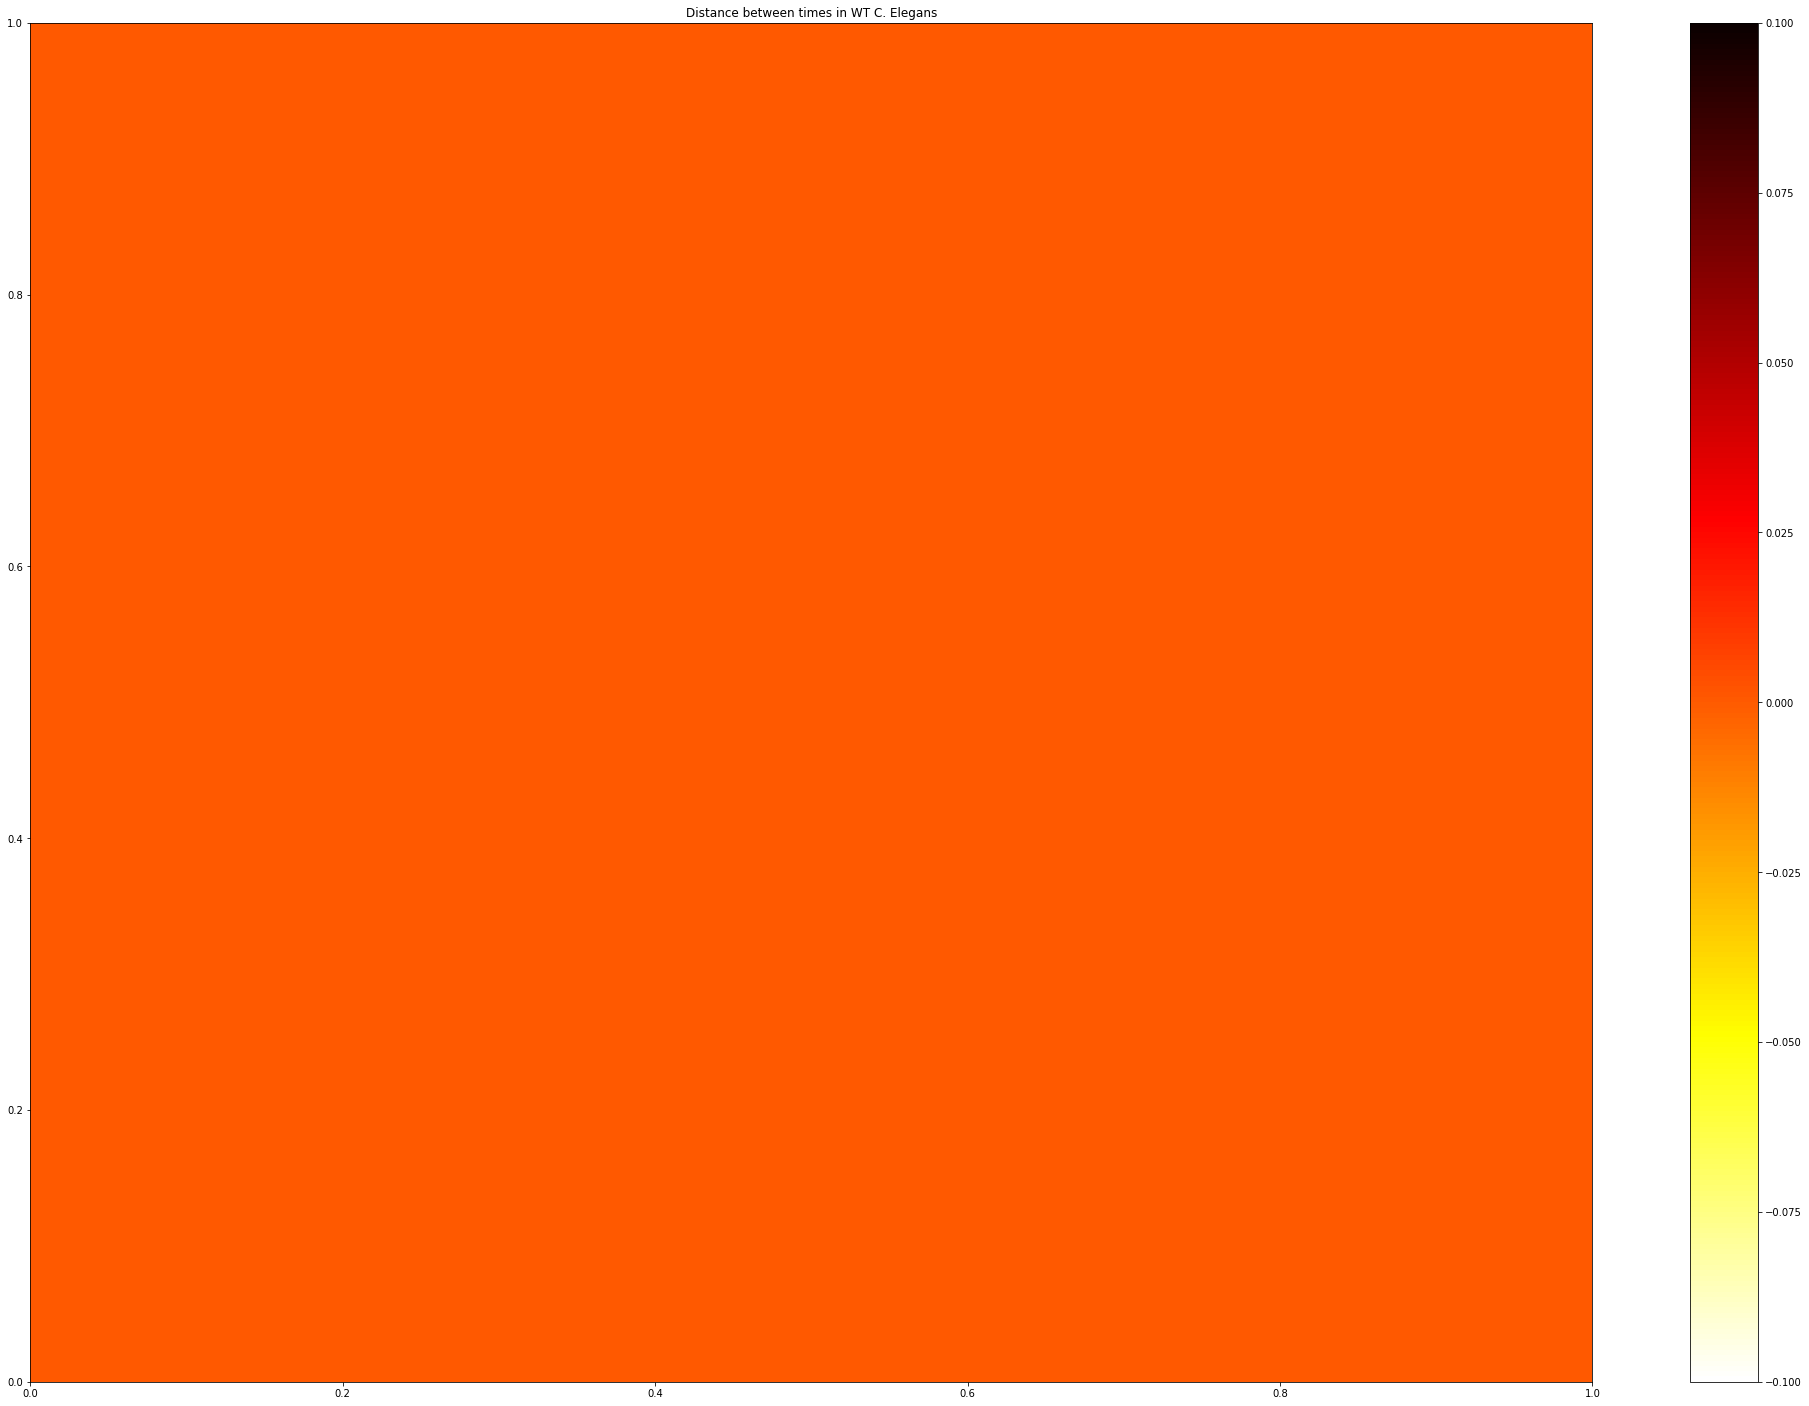

ABala
-144.30662476847078
F55A3.7 ABp branch
1


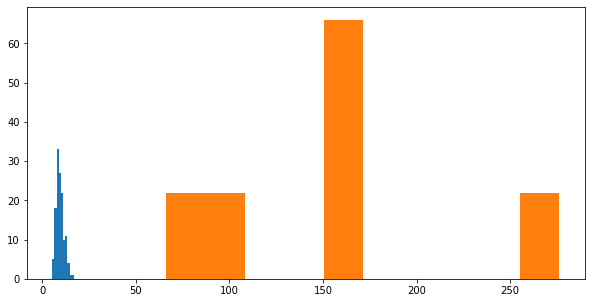

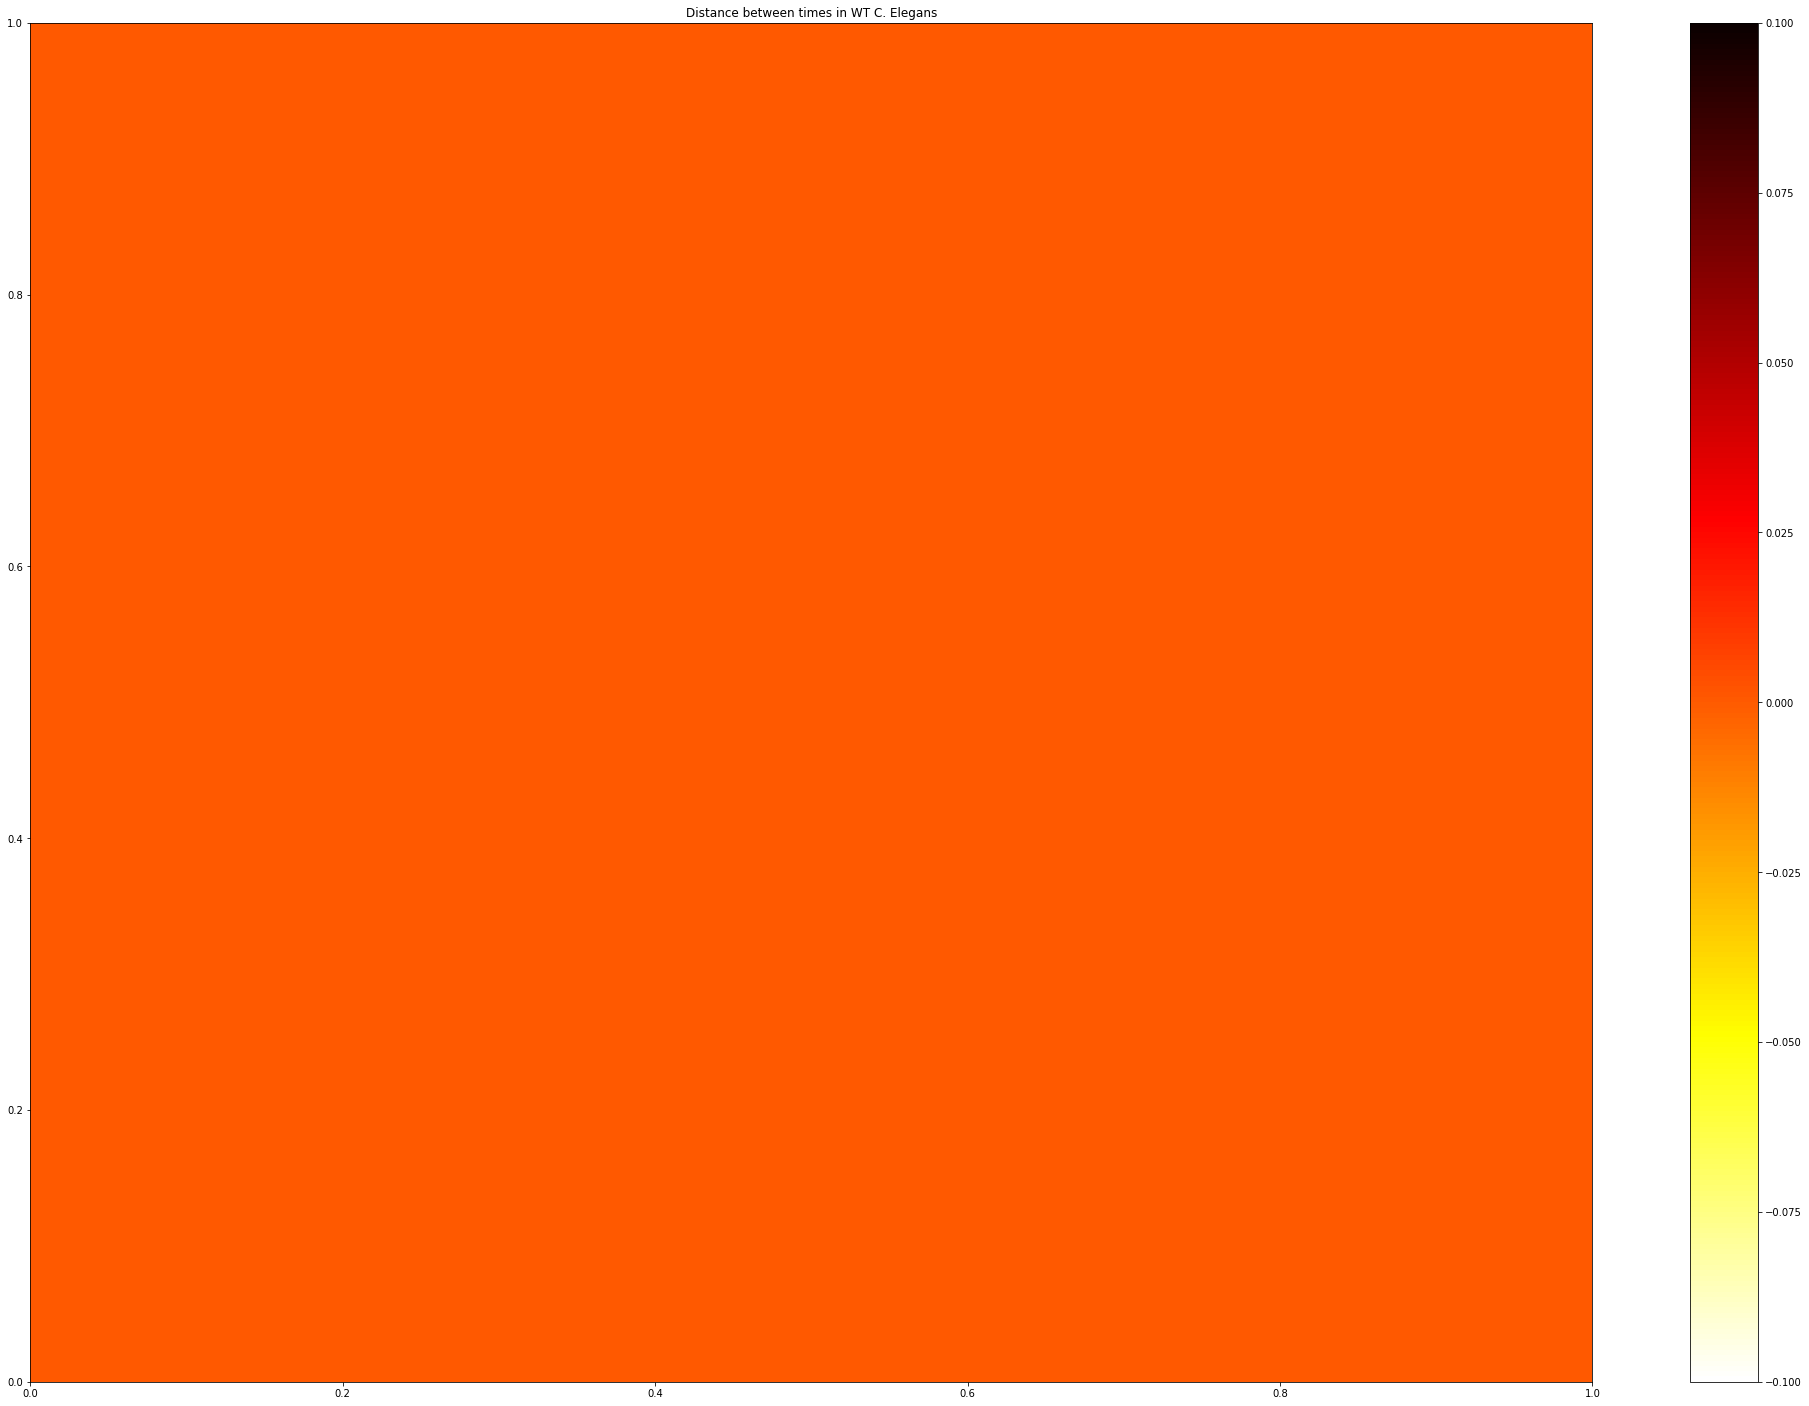

ABp
-364.44270461839335
F55A3.7 E branch
17


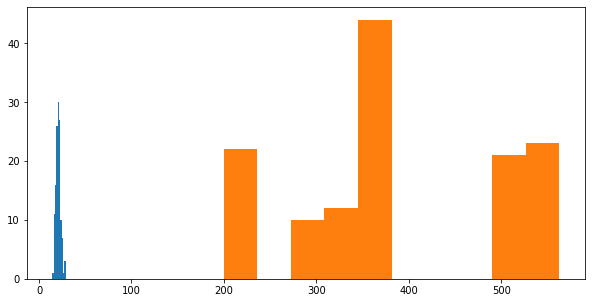

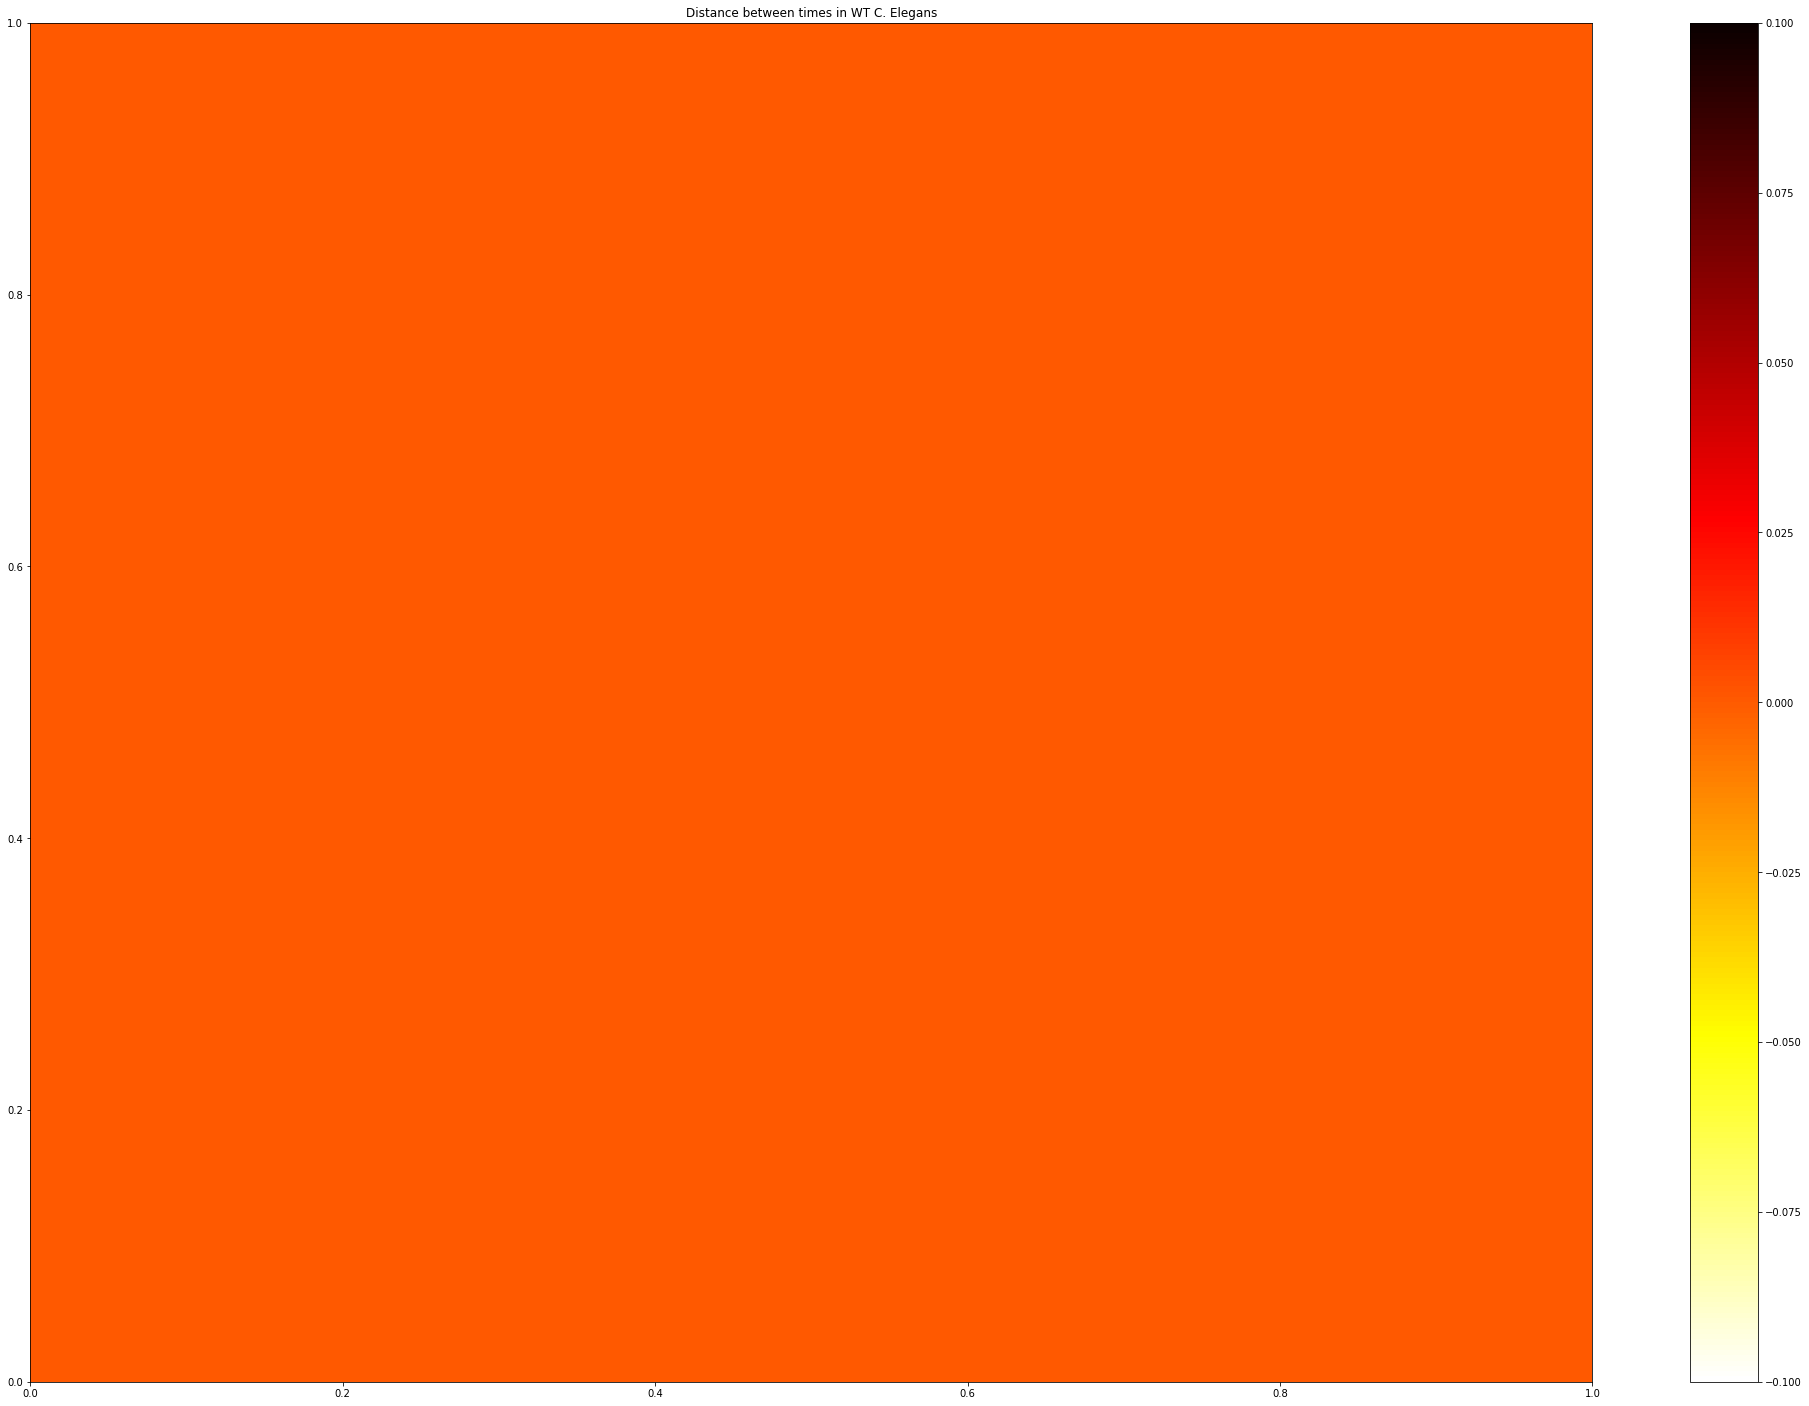

E
-127.8039184920346


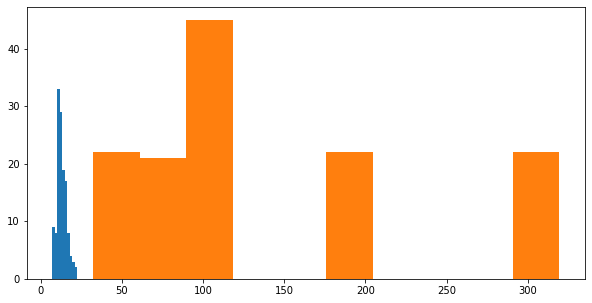

In [1588]:
protein_tag = 'F55A3.7'
cells_of_interest = Undefined_trans[protein_tag];grid_indices = grid_indices_dict[protein_tag];grid_dims = grid_dimensions[protein_tag]

for n in cells_of_interest:
    b_mat = []
    for a in inlier_ref:
        t_row = [];j_row = [];b_row = [];
        for b in (np.where(RNAi_name_array == protein_tag)[0]+30).tolist(): b_row.append(branch_distance(node_comparison_trimmer(fulldictset[a],n),node_comparison_trimmer(fulldictset[b],n)))
        b_mat.append(b_row)
    b_mat = np.mat(b_mat)
    print(protein_tag,n,'branch')
    print(root_cells_comp.index(n))
    plot_2_examples(['hot_r'],np.mat([0]))    
    pop1 = vals_of_selfsubtrees[root_cells_comp.index(n)];pop2 = np.mat(b_mat).flatten().tolist()[0]
    pop1 = pop1[0:len(pop2)]
    print(n)
    plt.hist(np.array(pop1));plt.hist(np.array(pop2))
    print(np.mean(pop1) - np.mean(pop2))

In [1430]:
qf = pd.read_csv('Fate_trans.csv', header=None)
qf = qf.fillna('0')
Fate_transforms = pd.DataFrame(qf).to_numpy()

In [1431]:
Fate_transforms_gene_index = Fate_transforms[:,0].tolist()
Fate_transforms_gene_index = np.array([each_string.upper() for each_string in Fate_transforms_gene_index])
Fate_transforms_gene_index

array(['GENE', 'APX-1', 'ATX-2', 'C49H3.8', 'CAMT-1', 'CDC-25.1',
       'CDC-37', 'CEH-24', 'CHAF-2', 'CHK-1', 'CLS-2', 'CPL-1', 'CSN-4',
       'CUL-1', 'CUL-2', 'CUL-3', 'DIV-1', 'DLC-1', 'DLI-1', 'DRH-3',
       'F23F1.5', 'F35F11.1', 'F44B9.8', 'GEI-17', 'GLD-2', 'GLP-1',
       'GPB-1', 'GSK-3', 'HDA-1', 'HMP-2', 'LAG-1', 'LET-502', 'LIN-23',
       'MBK-2', 'MEI-1', 'MEX-3', 'MEX-5', 'MOM-2', 'MOM-5', 'NMY-2',
       'NPP-4', 'NUD-1', 'OMA-1/2', 'PAD-1', 'PAR-2', 'PAR-3', 'PAR-6',
       'PIE-1', 'PKC-3', 'POP-1', 'POS-1', 'PPFR-4', 'PUF-3', 'RAB-5',
       'RAB-7', 'RAD-51', 'RAN-4', 'RBA-1', 'RFC-3', 'RGA-3', 'RUVB-1',
       'SEL-8', 'SKN-1', 'SKR-1/2', 'SRC-1', 'SUF-1', 'T11G6.8',
       'TAG-256', 'TAT-5', 'TSR-1', 'UBA-1', 'UBC-12', 'VPS-4', 'WWP-1',
       'Y53F4B.22', 'ZYG-11', 'ZYG-12'], dtype='<U9')

In [1524]:
protein_tag = 'OMA-1/2'
Fate_transforms[np.where(Fate_transforms_gene_index== protein_tag)[0]]

array([['oma-1/2', '0', '0', '0', '0', '0', 'ABal', '0', '0', '0',
        'ABarp', '0', '0', '0', '0', 'ABpla', '0', '0', 'C', '0', '0',
        '0', '0', '0', '0', '0']], dtype=object)

In [1525]:
Departing_cells = Fate_transforms[0]
Departing_cells

array(['Gene', 'P0', 'AB', 'ABa', 'ABp', 'ABal', 'ABar', 'ABpl', 'ABpr',
       'ABala', 'ABalp', 'ABara', 'ABarp', 'ABpla', 'ABplp', 'ABpra',
       'ABprp', 'P1', 'EMS', 'P2', 'MS', 'E', 'C', 'P3', 'D', 'P4'],
      dtype=object)

In [1526]:
Destination_Fate = Fate_transforms[np.where(Fate_transforms_gene_index== protein_tag)[0]]
cell_references_of_interest = np.where(Destination_Fate > '0')[1][1:]
Departing_cells = Departing_cells[cell_references_of_interest]
Destination_Fate_cells = Destination_Fate[0][cell_references_of_interest]
Departing_cells,Destination_Fate_cells

(array(['ABar', 'ABalp', 'ABpra', 'EMS'], dtype=object),
 array(['ABal', 'ABarp', 'ABpla', 'C'], dtype=object))

In [1527]:
picked_change = 0
Departing_cells[picked_change],Destination_Fate_cells[picked_change]

('ABar', 'ABal')

In [1528]:
embryonic_parser = [inlier_ref]
altered_embryo_dict = []
for n in embryonic_parser:
    for m in n:
        altered_embryo_dict.append(node_comparison_trimmer(fulldictset[m],Departing_cells[picked_change]))
    for m in n:
        altered_embryo_dict.append(node_comparison_trimmer(fulldictset[m],Destination_Fate_cells[picked_change]))
for n in embryos_of_interest:
    altered_embryo_dict.append(node_comparison_trimmer(fulldictset[n],Departing_cells[picked_change]))

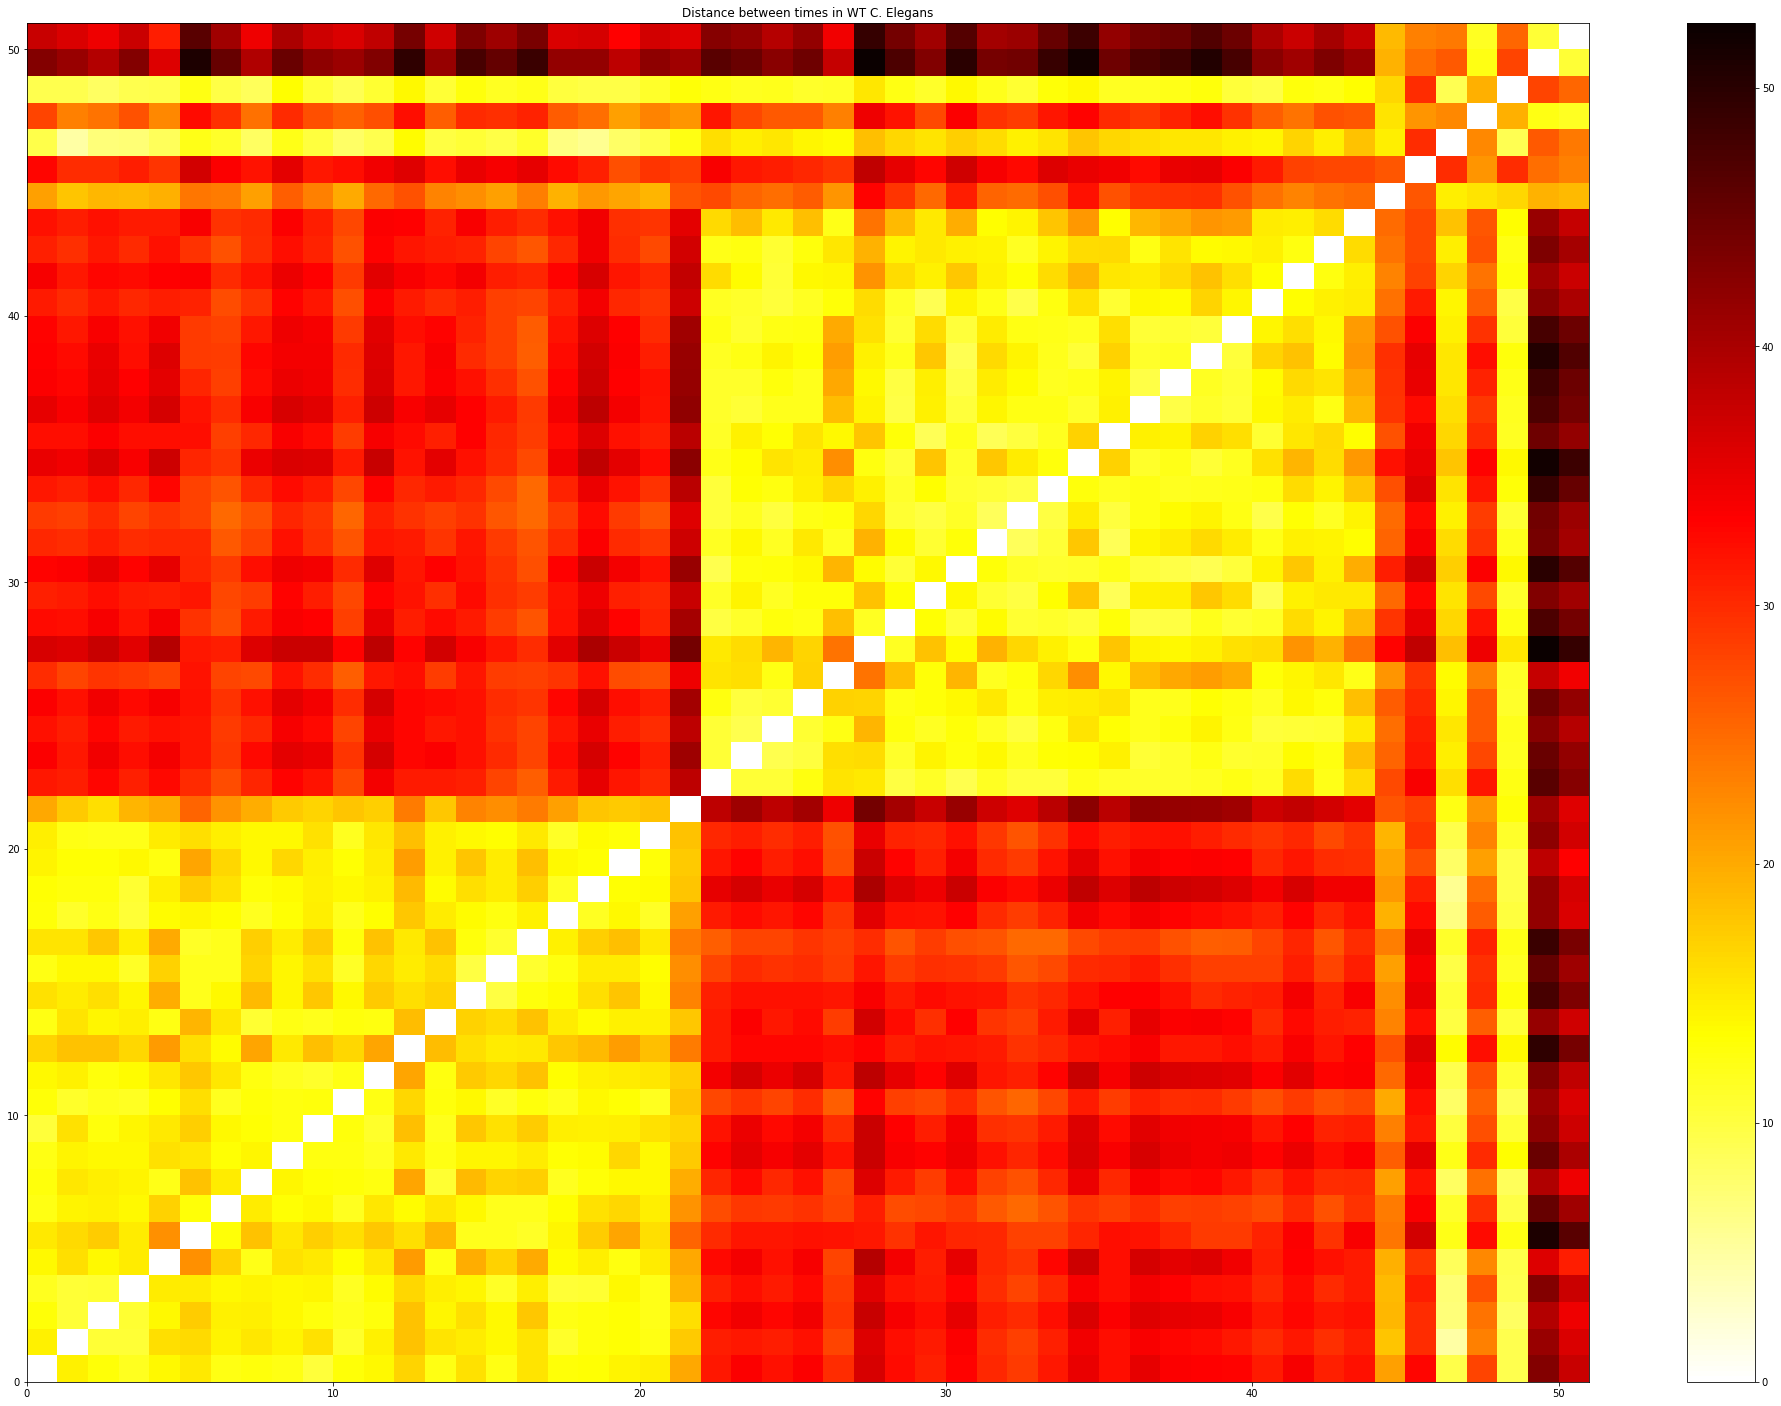

In [1529]:
b_mat = []
for a in altered_embryo_dict:
    b_row = []
    for b in altered_embryo_dict:
        b_row.append(branch_distance(a,b))
    b_mat.append(b_row)
b_mat = np.mat(b_mat)
plot_2_examples(['hot_r'],np.mat(b_mat))

In [1530]:
Departing_cells[picked_change],Destination_Fate_cells[picked_change]

('ABar', 'ABal')

(array([35., 36., 12., 15., 22., 24.,  8., 14., 15.,  8.]),
 array([ 9.79795897, 14.07078147, 18.34360397, 22.61642646, 26.88924896,
        31.16207146, 35.43489396, 39.70771645, 43.98053895, 48.25336145,
        52.52618395]),
 <BarContainer object of 10 artists>)

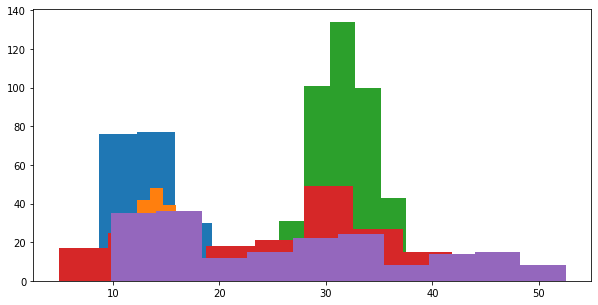

In [1532]:
#plt.hist(self_comp(b_mat[0:21,0:21]))
plt.hist(self_comp(b_mat[21:42,21:42]))
plt.hist(self_comp(b_mat[0:21,0:21]))

plt.hist(np.array(b_mat[21:42,0:21]).flatten())

plt.hist(np.array(b_mat[0:21,42:]).flatten())
plt.hist(np.array(b_mat[21:42,42:]).flatten())

In [1494]:
self_comp(b_mat[0:21,0:21]).shape,self_comp(b_mat[21:42,21:42]).shape,np.array(b_mat[0:21,42:]).shape,np.array(b_mat[0:21,42:]).shape,np.array(b_mat[21:42,42:]).shape

((210,), (210,), (21, 9), (21, 9), (21, 9))

In [1511]:
go2 = self_comp(b_mat[0:21,0:21]).tolist();
go = np.array(b_mat[0:21,42:]).flatten().tolist();

print(novel_two_sample_permutation_test(go2,go,5000))
t,p = ttest_ind(go, go2, equal_var=False)
print(t,p)
t,p = stats.brunnermunzel(go, go2)
print(t,p)

0.0
22.1280839275552 2.26650652762667e-55
-35.518663889823415 4.2830591116314205e-93


In [1512]:
go2 = self_comp(b_mat[0:21,21:42]).tolist();
go = np.array(b_mat[21:42,42:]).flatten().tolist();

print(novel_two_sample_permutation_test(go2,go,5000))
t,p = ttest_ind(go, go2, equal_var=False)
print(t,p)
t,p = stats.brunnermunzel(go, go2)
print(t,p)

0.0
-4.120990932930545 5.009958490023206e-05
6.28414619517343 1.47367384961683e-09
